# Check science reply questions
Let's look at some data related to sharing new science articles and the questions that people pose in response to the articles.

We'll see how readily we can predict author background using the questions.

In [8]:
## get Reddit data!!
from datetime import datetime
from psaw import PushshiftAPI
from tqdm import tqdm
# from data_helpers import load_reddit_api
# reddit_api, pushshift_api = load_reddit_api('../../data/auth_data/reddit_auth.csv')
pushshift_api = PushshiftAPI()
date_range = ['2020-01-01', '2021-09-01']
date_range = list(map(lambda x: int(datetime.strptime(x, '%Y-%m-%d').timestamp()), date_range))
subreddit = 'science'
filter_fields = ['url', 'title', 'author', 'score', 'text', 'created_utc', 'id', 'upvote_ratio', 'num_comments']
submissions = pushshift_api.search_submissions(q="*", after=date_range[0], before=date_range[1],
                                               subreddit=subreddit, filter=filter_fields)
submissions_results = []
for s in tqdm(submissions):
    submissions_results.append(s)

0it [00:00, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
1001it [00:05, 286.60it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
47091it [07:52, 99.66it/s] 


In [14]:
## convert to data frame
import pandas as pd
submission_data = pd.DataFrame(submissions_results)
display(submission_data.head())

,author,created_utc,id,num_comments,score,title,upvote_ratio,url,created,d_
0,talismanbrandi,1630462648,pfkdt5,3,1,Socio-economic disparities and COVID-19 in the...,1.0,https://www.reddit.com/r/science/comments/pfkd...,1630480648.0,"{'author': 'talismanbrandi', 'created_utc': 16..."
1,BeforeYourBBQ,1630462436,pfkbn2,3,1,Comparing SARS-CoV-2 natural immunity to vacci...,1.0,https://www.medrxiv.org/content/10.1101/2021.0...,1630480436.0,"{'author': 'BeforeYourBBQ', 'created_utc': 163..."
2,key__lime_pie,1630462250,pfk9q9,2,1,Scientists Figured Out How Much Exercise You N...,1.0,https://www.sciencealert.com/scientists-figure...,1630480250.0,"{'author': 'key__lime_pie', 'created_utc': 163..."
3,key__lime_pie,1630462179,pfk90j,468,1,Female octopuses throw shells at males annoyin...,1.0,https://www.independent.co.uk/climate-change/n...,1630480179.0,"{'author': 'key__lime_pie', 'created_utc': 163..."
4,Doozenburg,1630461660,pfk3ts,2,1,Who is Anti-Vax Dr. Wendy Menigoz?,1.0,https://www.slugbrain.com/post/who-is-anti-vax...,1630479660.0,"{'author': 'Doozenburg', 'created_utc': 163046..."


Let's collect all comments from the same time frame, and align them to submissions afterward.

In [ ]:
date_range = ['2020-01-01', '2021-09-01']
date_range = list(map(lambda x: int(datetime.strptime(x, '%Y-%m-%d').timestamp()), date_range))
subreddit = 'science'
filter_fields = ['id', 'link_id', 'parent_id', 'body', 'author', 'created_utc', 'score']
comments = pushshift_api.search_comments(after=date_range[0], before=date_range[1],
                                         subreddit=subreddit, filter=filter_fields)
comments_results = []
for c in tqdm(comments):
    comments_results.append(c)

0it [00:00, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
901it [00:03, 289.96it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
18800it [03:16, 23.04it/s] /home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 502
  warnings.warn("Got non 200 code %s" % response.status_code)
907905it [2:33:53, 83.42it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending outp

In [34]:
## combine/clean
comment_data = pd.DataFrame(comments_results)
# drop deleted data
comment_data = comment_data[(comment_data.loc[:, 'author']!='[deleted]') &
                            (comment_data.loc[:, 'body']!='[deleted]')]
# fix ID vars
comment_data = comment_data.assign(**{
    'link_id' : comment_data.loc[:, 'link_id'].apply(lambda x: x.split('_')[1]),
    'parent_id' : comment_data.loc[:, 'parent_id'].apply(lambda x: x.split('_')[1]),
})
# drop extra data
comment_data.drop('d_', axis=1, inplace=True)
display(comment_data.head())
print(comment_data.shape[0])

,author,body,created_utc,id,link_id,parent_id,score,created
0,Etna,"oh I misread, it's the males that are being an...",1630468787,hb5b6ss,pfk90j,hb5b25v,27,1.630487e+09
3,lalauna,Please tell me something i didn't know before.,1630468726,hb5b2zz,pfgvrw,pfgvrw,1,1.630487e+09
4,DivineBanana,I haven't followed the debate but I'm sure it'...,1630468726,hb5b2zy,pf5phr,hb58igp,3,1.630487e+09
5,_MASTADONG_,I just linked you to 2 articles on fact checki...,1630468723,hb5b2sg,pfgvrw,hb5adks,4,1.630487e+09
8,Etna,It's because they can't talk,1630468713,hb5b25v,pfk90j,pfk90j,37,1.630487e+09


2196985


In [35]:
## restrict to comment/submission matches
submission_comment_data = pd.merge(submission_data, comment_data, left_on='id', right_on='link_id', how='inner')
# fix col names
submission_comment_data.rename(columns={
    x : x.replace('_x', '_submission') 
    for x in list(filter(lambda x: x.endswith('_x'), submission_comment_data.columns))
}, inplace=True)
submission_comment_data.rename(columns={
    x : x.replace('_y', '_comment') 
    for x in list(filter(lambda x: x.endswith('_y'), submission_comment_data.columns))
}, inplace=True)
submission_comment_data = submission_comment_data[submission_comment_data.loc[:, 'link_id']==submission_comment_data.loc[:, 'parent_id']]

In [36]:
submission_comment_data.shape[0]

465354

In [52]:
## clean text
import re
RETURN_MATCHER = re.compile('[\n\r]')
submission_comment_data = submission_comment_data.assign(**{
    'body' : submission_comment_data.loc[:, 'body'].apply(lambda x: RETURN_MATCHER.sub(' ', x))
})
## filter questions
from nltk.tokenize import sent_tokenize
submission_comment_data = submission_comment_data.assign(**{
    'reply_sents' : submission_comment_data.loc[:, 'body'].apply(lambda x: sent_tokenize(x))
})
# look for questions!
import re
question_matcher = re.compile('\?$')
submission_comment_data = submission_comment_data.assign(**{
    'reply_questions' : submission_comment_data.loc[:, 'reply_sents'].apply(lambda x: list(filter(lambda y: question_matcher.search(y) is not None, x)))
})
submission_question_data = submission_comment_data[submission_comment_data.loc[:, 'reply_questions'].apply(len)>0]
## flatten
flat_submission_question_data = []
for idx_i, data_i in submission_question_data.iterrows():
    for q_j in data_i.loc['reply_questions']:
        data_j = data_i.copy().drop('reply_questions')
        data_j.loc['reply_question'] = q_j
        flat_submission_question_data.append(data_j)
flat_submission_question_data = pd.concat(flat_submission_question_data, axis=1).transpose()
print(f'{flat_submission_question_data.shape[0]} questions total')

130878 questions total


In [56]:
## look at sample questions => clarification questions? self-contained? related to post?
## sample questions
pd.set_option('display.max_colwidth', 1000)
display(flat_submission_question_data.loc[:, 'reply_question'].iloc[:10].values)

array(['die for the economy?', 'how about we topple you instead?',
       'Are we really trying to blame covid for why my political leadership is incompetent and worthless?',
       'You mean covid unveils a psychological burden of perpetual political unrest in USA?',
       'Psychological burden of the virus itself, or the various lockdown measures that forced people to isolate?',
       'Im slow, but i believe the abstract reads that the native species are evolving to become more cannibalistic themselves eating more of the young of the invaders?',
       'So, when they collide, they destroy each other.”  [source](https://www.cam.ac.uk/research/news/astronomers-show-how-planets-form-in-binary-systems-without-getting-crushed)  Am I missing something here?',
       'How would these evictions **double** the Covid rate in an **area**?',
       'Have I misread something?',
       "Don't you care about the environment?"], dtype=object)

Let's limit the questions to have at least X words.

In [60]:
from nltk.tokenize import WordPunctTokenizer
min_question_words = 10
tokenizer = WordPunctTokenizer()
valid_submission_question_data = flat_submission_question_data[flat_submission_question_data.loc[:, 'reply_question'].apply(lambda x: len(tokenizer.tokenize(x)) >= min_question_words)]
display(valid_submission_question_data.loc[:, 'reply_question'].iloc[:10].values)

array(['Are we really trying to blame covid for why my political leadership is incompetent and worthless?',
       'You mean covid unveils a psychological burden of perpetual political unrest in USA?',
       'Psychological burden of the virus itself, or the various lockdown measures that forced people to isolate?',
       'Im slow, but i believe the abstract reads that the native species are evolving to become more cannibalistic themselves eating more of the young of the invaders?',
       'So, when they collide, they destroy each other.”  [source](https://www.cam.ac.uk/research/news/astronomers-show-how-planets-form-in-binary-systems-without-getting-crushed)  Am I missing something here?',
       'How would these evictions **double** the Covid rate in an **area**?',
       'Wait, who was saying there would be a pandemic baby boom and why?',
       "Isn't it established that stress and uncertainty eliminate the desire to be parents, or is that just my intuition?",
       'The baby boo

In [ ]:
## save data for posterity!!
valid_submission_question_data.to_csv('science_submission_question_data.gz', sep='\t', compression='gzip', index=False)

In [2]:
import pandas as pd
valid_submission_question_data = pd.read_csv('science_submission_question_data.gz', sep='\t', compression='gzip')

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
## TODO: mine previous history for N=10000 commenters; extract location + age + gender (?)
from tqdm import tqdm
import numpy as np
np.random.seed(123)
from psaw import PushshiftAPI
pushshift_api = PushshiftAPI()
N_commenters = 10000
N_previous_comments = 1000
sample_question_author_data = valid_submission_question_data.sort_values(['author_comment', 'created_utc_comment'], ascending=True).drop_duplicates('author_comment').loc[:, ['author_comment', 'created_utc_comment']]
sample_question_author_data = sample_question_author_data.sample(N_commenters, replace=False, random_state=123)
sample_question_author_prior_data = []
author_filter_cols = ['body', 'id', 'created_utc', 'author', 'subreddit']
for idx_i, data_i in tqdm(sample_question_author_data.iterrows()):
    author_i = data_i.loc['author_comment']
    time_i = int(data_i.loc['created_utc_comment'])
    prior_comments_i = list(pushshift_api.search_comments(author=author_i, limit=N_previous_comments, before=time_i, filter=author_filter_cols))
    prior_comments_i = pd.DataFrame(prior_comments_i)
    if('d_' in prior_comments_i.columns):
        prior_comments_i.drop('d_', axis=1, inplace=True)
    sample_question_author_prior_data.append(prior_comments_i)
sample_question_author_prior_data = pd.concat(sample_question_author_prior_data)

0it [00:00, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
2it [00:03,  2.19s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
3099it [6:11:34,  6.67s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_l

In [5]:
sample_question_author_prior_data.to_csv('science_submission_question_reply_author_data.gz', sep='\t', compression='gzip', index=False)

In [2]:
## reload
import pandas as pd
valid_submission_question_data = pd.read_csv('science_submission_question_data.gz', sep='\t', compression='gzip')
sample_question_author_prior_data = pd.read_csv('science_submission_question_reply_author_data.gz', sep='\t', compression='gzip')
sample_question_author_prior_data.dropna(subset=['body'], inplace=True)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (0,1,2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
pd.set_option('display.max_colwidth', 1000)
display(sample_question_author_prior_data.head())

,author,body,created_utc,id,subreddit,created
0,mahogany555,"You're not even Scottish, are you?",1582310896,fiayfoz,ScottishPeopleTwitter,1.582329e+09
1,mahogany555,"'The people of Scotland' don't spell it that way, losers seeking attention on reddit do.",1582298322,fiacrvb,ScottishPeopleTwitter,1.582316e+09
2,mahogany555,"Firstly, most of these people probably aren't Scots. Secondly the ones writing this are loser millennials doing it to look cool on reddit...\n\nPlease tell me normal scottish people don't do this and would thoroughly mock anyone who would.",1582291726,fia35ak,ScottishPeopleTwitter,1.582310e+09
3,mahogany555,"No, I definitely don't. I just stick to the 80000000 existing words that make up the language I'm writing in. Crazy, I know...",1582258926,fi99f50,ScottishPeopleTwitter,1.582277e+09
4,mahogany555,Do they that's super interesting...\n\nHere's the word 'dog' from the dictionary of that 'language'\n\nhttps://dsl.ac.uk/results/dog,1582258153,fi98eh0,ScottishPeopleTwitter,1.582276e+09


In [37]:
## check for self-disclosure statements
import re
self_disclosure_matcher = re.compile(f'(I\'m|I am|I live)')
print(self_disclosure_matcher.search('I live in MI'))
sample_question_author_prior_data = sample_question_author_prior_data.assign(**{
    'body_contain_self_disclosure' : sample_question_author_prior_data.loc[:, 'body'].apply(lambda x: self_disclosure_matcher.search(x) is not None)
})
display(f'{sample_question_author_prior_data.loc[:, "body_contain_self_disclosure"].sum()}/{sample_question_author_prior_data.shape[0]}')

<re.Match object; span=(0, 6), match='I live'>


'416971/6804000'

In [26]:
COPULA_LEMMA = 'be'
EXIST_LEMMA = 'live'
GENDER_MATCHER = re.compile('^(man|woman|male|female)$')
AGE_NUM_MATCHER = re.compile('[0-9]+')
def collect_propn(token):
    loc_noun_parts = [token]
    location_children = list(filter(lambda x: x.pos_=='PROPN', token.children))
    while(len(location_children) > 0):
        loc_noun_part = location_children.pop()
        loc_noun_parts.append(loc_noun_part)
        location_children += list(filter(lambda x: x.pos_=='PROPN', loc_noun_part.children))
    # sort noun parts
    loc_noun_parts = list(sorted(loc_noun_parts, key=lambda x: x.idx))
    loc_noun = ' '.join(list(map(lambda x: x.lemma_, loc_noun_parts)))
    return loc_noun
def extract_self_statement_targets(sent, pipeline=None):
    if(pipeline is not None):
        parse = pipeline(sent)
    else:
        parse = sent
    identity_attributes = []
    parse_sents = list(parse.doc.sents)
    for parse_sent in parse_sents:
        for token in parse_sent:
            # get children nouns for "I" via root
            if(token.lemma_ == 'I' and token.dep_ == 'nsubj'):
                token_root_ancestors = list(filter(lambda x: x.dep_=='ROOT', token.ancestors))
    #             print(f'parse ents = {list(map(lambda x: x.label_, parse.ents))}')
                loc_ents = list(filter(lambda x: x.label_=='GPE', parse.ents))
                if(len(token_root_ancestors) > 0):
                    token_root = token_root_ancestors[0]
                    root_children = list(token_root.children)
                    if(token_root.lemma_ == COPULA_LEMMA):
                        for child in root_children:
                            if(child.dep_ == 'attr'):
                                # gender
                                gender_match = GENDER_MATCHER.match(child.lemma_)
                                if(gender_match is not None):
                                    identity_attributes.append(['gender', gender_match.group(0)])
                                # age => NOPE false positives abound
#                                 age_match = AGE_NUM_MATCHER.match(child.lemma_)
#                                 if(age_match is not None):
#                                     identity_attributes.append(['age', age_match.group(0)])
                            # age
                            elif(child.dep_ == 'acomp'):
                                if(child.lemma_ == 'old'):
                                    # look for children ("30 years old")
                                    age_children_1 = list(child.children)
                                    if(len(age_children_1) > 0 and age_children_1[0].lemma_=='year'):
                                        age_children_2 = list(age_children_1[0].children)
                                        if(len(age_children_2) > 0):
                                            age_match = AGE_NUM_MATCHER.match(age_children_2[0].lemma_)
                                            if(age_match is not None):
                                                identity_attributes.append(['age', age_match.group(0)])
                            # location
                            elif(child.dep_ == 'prep' and child.lemma_ == 'from'):
                                location_children_1 = list(child.children)
                                if(len(location_children_1) > 0 and location_children_1[0].pos_ == 'PROPN'):
                                    ent_start = location_children_1[0].i
    #                                 child_1_idx = location_children_1[0].idx
    #                                 child_1_ent = 
    #                                 main_loc = location_children_1[0]
    #                                 loc_noun = collect_propn(main_loc)
                                    # find ENT that contains child
    #                                 print(f'ent start = {ent_start}')
    #                                 print(f'{[(x.start, x.end) for x in loc_ents]}')
                                    containing_loc_ents = list(filter(lambda x: x.start <= ent_start and x.end >= ent_start, loc_ents))
    #                                 print(f'containing loc ents {containing_loc_ents}')
                                    if(len(containing_loc_ents) > 0):
                                        loc_noun = containing_loc_ents[0].text
                                        identity_attributes.append(['location', loc_noun])
                    # "I live in the US"
                    elif(token_root.lemma_ == EXIST_LEMMA):
                        root_prep_children = list(filter(lambda x: x.lemma_=='in' and x.dep_=='prep', token_root.children))
                        if(len(root_prep_children) > 0):
                            prep_children_2 = list(filter(lambda x: x.pos_ == 'PROPN', root_prep_children[0].children))
                            if(len(prep_children_2) > 0):
                                ent_start = prep_children_2[0].i
                                containing_loc_ents = list(filter(lambda x: x.start <= ent_start and x.end >= ent_start, loc_ents))
                                if(len(containing_loc_ents)):
                                    loc_noun = containing_loc_ents[0].text
                                    identity_attributes.append(['location', loc_noun])
    return identity_attributes

In [38]:
import re
# dumb
# self_statement = '(I\'m|I am)'
# age_matcher = f'({self_statement} [0-9]+ years old)|({self_statement} a [0-9]+ yo )'
# gender_matcher = f'({self_statement} a[ a-zA-Z]? (man|woman|male|female))'
# smart => parse then extract
import spacy
nlp_pipeline = spacy.load('en_core_web_sm')
# gender_dep = attr ("I'm a man")
# age_dep = acomp ("I'm 50 years old")
# loc_dep = prep ("I live in Michigan")
test_sents = [
    'I am 30 years old',
    'I am a woman',
    'I live in London, England',
]
for sent in test_sents:
    sent_attr = extract_self_statement_targets(sent, nlp_pipeline)
    print(f'sent = {sent} has attr {sent_attr}')

sent = I am 30 years old has attr [['age', '30']]
sent = I am a woman has attr [['gender', 'woman']]
sent = I live in London, England has attr [['location', 'London']]


OK! We have an extremely brittle attribute extraction pipeline.

In [7]:
# nope
# ## get parses first
# from tqdm import tqdm
# tqdm.pandas()
# from pandarallel import pandarallel
# # pandarallel.initialize(nb_workers=8, progress_bar=True)
# sample_question_author_prior_data = sample_question_author_prior_data.assign(**{
#     'body_parse' : list(tqdm(nlp_pipeline.pipe(sample_question_author_prior_data.loc[:, 'body'].values, batch_size=1000)))
# })

In [8]:
## parallelized pipeline
# https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Option-3:-Parallelize-the-work-using-joblib
from tqdm import tqdm
from joblib import Parallel, delayed
N_JOBS=7
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))
def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]
def process_chunk(texts):
    proc_results = []
    for doc in nlp_pipeline.pipe(texts, batch_size=20):
#         preproc_pipe.append(lemmatize_pipe(doc))
        proc_results.append(doc)
    return proc_results
def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=N_JOBS, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in tqdm(chunker(texts, len(texts), chunksize=chunksize)))
    result = executor(tasks)
    return flatten(result)

In [ ]:
# takes too much memory!!
# body_parse = preprocess_parallel(sample_question_author_prior_data.loc[:, 'body'].values, chunksize=1000)
# print(body_parse[0])

504it [18:22,  2.04s/it]

In [105]:
# show "men"/"women" subreddits
subreddit_counts = sample_question_author_prior_data.loc[:, 'subreddit'].value_counts()
subreddit_counts.index = list(map(lambda x: str(x.lower()), subreddit_counts.index))
display(subreddit_counts.loc[list(filter(lambda x: re.search('(^men)|(men$)', x) is not None, subreddit_counts.index))].sort_values(ascending=False).head(25))
display(subreddit_counts.loc[list(filter(lambda x: re.search('(^women)|(women$)', x) is not None, subreddit_counts.index))].sort_values(ascending=False).head(25))
# show location subreddits
display(subreddit_counts.loc[['nyc', 'losangeles', 'chicago', 'houston', 'phoenix']])
# show age subreddits
display(subreddit_counts.loc[list(filter(lambda x: re.search('(^old)|(old$)|(^young)|(young$)', x), subreddit_counts.index))].head(20))

askmen                   16907
askwomen                  3898
mensrights                2745
menwritingwomen           1279
menslib                    903
whereareallthegoodmen      583
mentalhealth               513
watchmen                   453
menopause                  444
mensa                      299
xmen                       291
redpillwomen               274
mendrawingwomen            230
ramen                      208
askgaymen                  204
armoredwomen               187
madmen                     150
adhdwomen                  137
mentalillness              123
menkampf                   103
women                       99
menshealth                  59
men                         55
autisminwomen               50
menieres                    48
Name: subreddit, dtype: int64

askwomen            3898
menwritingwomen     1279
redpillwomen         274
mendrawingwomen      230
armoredwomen         187
adhdwomen            137
womenshealth         109
women                 99
autisminwomen         50
womenofcolor          20
prettyolderwomen      17
womensstreetwear      17
justhotwomen          16
womensrightsnews      14
bluecollarwomen       11
womenengineers        10
womenwhodontsell       9
darkestwomen           8
whipped_women          8
womenwritingmen        7
womenbendingover       7
actualwomen            5
womensfashion          5
womenstyleadvice       4
womenofcolorxxx        4
Name: subreddit, dtype: int64

nyc           3219
losangeles    3279
chicago       4038
houston       2261
phoenix        714
Name: subreddit, dtype: int64

oldschoolcool          15862
oldpeoplefacebook        446
oldphotosinreallife      364
youngpeopleyoutube       356
gold                     293
old_recipes              266
galaxyfold               184
goforgold                180
oldschoolhot             173
negativewithgold         141
fuckimold                121
oldmandog                117
youngjustice             116
oldschoolcoolnsfw        110
oldfreefolk              107
cuckold                  106
gayyoungold              105
mold                      94
oldschoolcelebs           84
freezingfuckingcold       64
Name: subreddit, dtype: int64

In [41]:
## extract all attributes!!
from tqdm import tqdm
tqdm.pandas()
out_file_name = 'science_sample_reply_author_attrs.gz'
id_cols = ['author', 'created_utc']
self_disclosure_author_prior_data = sample_question_author_prior_data[sample_question_author_prior_data.loc[:, 'body_contain_self_disclosure']]
self_disclosure_author_prior_data = self_disclosure_author_prior_data.assign(**{
    'id_attrs' : self_disclosure_author_prior_data.loc[:, 'body'].progress_apply(lambda x: extract_self_statement_targets(x, nlp_pipeline))
})
# pandarallel => memory isssues
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers=8, progress_bar=True)
# sample_question_author_prior_data = sample_question_author_prior_data.assign(**{
#     'identity_attributes' : sample_question_author_prior_data.loc[:, 'body'].parallel_apply(lambda x: extract_self_statement_targets(x, nlp_pipeline)),
# #     'identity_attributes' : sample_question_author_prior_data.loc[:, 'body_parse'].progress_apply(lambda x: extract_self_statement_targets(x))
# })

100%|██████████| 416971/416971 [1:55:00<00:00, 60.42it/s]  


In [146]:
question_author_attribute_data = self_disclosure_author_prior_data[self_disclosure_author_prior_data.loc[:, 'id_attrs'].apply(lambda x: len(x) > 0)]
# get one line per author
flat_author_attribute_data = []
for author_i, data_i in tqdm(question_author_attribute_data.groupby('author')):
    attr_data_i = []
    for idx_j, data_j in data_i.iterrows():
        # keep track of dates!!
        date_j = data_j.loc['created_utc']
        for attr_k, val_k in data_j.loc['id_attrs']:
            attr_data_i.append({
                'author' : author_i,
                'date' : date_j,
                'attr' : attr_k,
                'val' : val_k
            })
    attr_data_i = pd.DataFrame(attr_data_i)
    attr_data_i.sort_values(['attr', 'date'], inplace=True, ascending=False)
    attr_data_i = attr_data_i.drop_duplicates(['attr'], keep='first').drop('date', axis=1)    
    attr_data_i = attr_data_i.pivot(index='author', columns=['attr'], values=['val']).reset_index()
    attr_data_i.columns = list(map(lambda x: x[0] if x[1]=='' else x[1], attr_data_i.columns))
    flat_author_attribute_data.append(attr_data_i)
flat_author_attribute_data = pd.concat(flat_author_attribute_data, axis=0)
display(flat_author_attribute_data.head())
## save for later
flat_author_attribute_data.to_csv('science_reply_author_attr_data.gz', sep='\t', compression='gzip', index=False)

100%|██████████| 3292/3292 [00:25<00:00, 129.86it/s]


,author,gender,age,location
0,-BluBone-,man,NaN,NaN
0,-Cerberus,man,41,KC
0,-Daetrax-,NaN,NaN,Denmark
0,-Negative-Karma,NaN,NaN,Kansas
0,-Nycter-,NaN,NaN,saudi arabia


Let's look at the label distribution.

In [51]:
all_attr = ['location', 'gender', 'age']
for attr_i in all_attr:
    print(flat_author_attribute_data.loc[:, attr_i].value_counts().head(10))

US            150
Canada        100
UK             81
Texas          79
California     62
Florida        52
America        49
Australia      39
Germany        35
USA            34
Name: location, dtype: int64
man       789
woman     275
male      184
female     48
Name: gender, dtype: int64
30    19
20    11
40    11
33    10
5     10
31     9
10     9
50     8
36     6
19     6
Name: age, dtype: int64


OK! This isn't the best but we'll see what we can do with the aggregate categories.

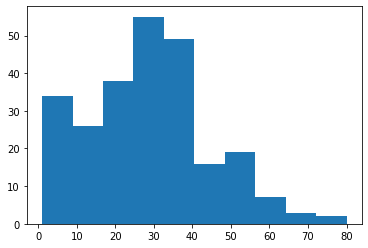

median age = 30.000


In [106]:
# fix age
import numpy as np
flat_author_attribute_data = flat_author_attribute_data.assign(**{
    'age' : flat_author_attribute_data.loc[:, 'age'].apply(lambda x: x if type(x) is float and np.isnan(x) else int(x))
})
max_age = 100
flat_author_attribute_data = flat_author_attribute_data[flat_author_attribute_data.loc[:, 'age'].apply(lambda x: np.isnan(x) or x <= max_age)]
## plot age distribution
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
age_vals = flat_author_attribute_data.loc[:, 'age'].dropna().astype(int)
plt.hist(age_vals)
plt.show()
print(f'median age = {age_vals.median():.3f}')

In [97]:
## fix location => geolocate!!
from geocoder import osm
unique_locations = flat_author_attribute_data.loc[:, 'location'].unique()
unique_location_geo_data = list(tqdm(map(lambda x: osm(x), unique_locations), total=len(unique_locations)))
unique_location_geo_data = list(map(lambda x: x.json()))
unique_location_geo_data_df = list(map(lambda x: x[0].json if len(x) > 0 else None, unique_location_geo_data))
[x.update({'location' : y}) for x,y in zip(unique_location_geo_data_df, unique_locations) if x is not None]
unique_location_geo_data_df = list(filter(lambda x: x is not None, unique_location_geo_data_df))
unique_location_geo_data_df = pd.DataFrame(unique_location_geo_data_df)#.assign(**{'location' : unique_locations})
unique_location_geo_data_df = unique_location_geo_data_df.loc[:, ['location', 'accuracy', 'country_code', 'state']]
# drop low-confidence scores
loc_conf_cutoff = 0.5
unique_location_geo_data_df = unique_location_geo_data_df[unique_location_geo_data_df.loc[:, 'accuracy'] >= loc_conf_cutoff]
# remove nan vals
unique_location_geo_data_df = unique_location_geo_data_df[unique_location_geo_data_df.loc[:, 'location'].apply(lambda x: type(x) is str)]
display(unique_location_geo_data_df.head(20))
display(unique_location_geo_data_df.loc[:, 'country_code'].value_counts().head(20))
display(unique_location_geo_data_df.loc[:, 'state'].value_counts().head(20))

,location,accuracy,country_code,state
2,Denmark,0.806806,dk,NaN
3,Kansas,0.826542,us,Kansas
4,saudi arabia,0.735263,sa,NaN
5,Germany,0.889681,de,NaN
6,Sweden,0.841632,se,NaN
7,Italy,0.883102,it,NaN
8,Atlanta,0.800803,us,Georgia
9,California,0.922136,us,California
10,Canada,0.976126,ca,NaN
11,Baltimore,0.765295,us,Maryland


us    259
gb     31
ca     29
cn     10
au     10
it      9
mx      6
nl      6
de      6
co      5
jp      5
in      4
es      4
fr      4
ch      4
th      3
kr      3
br      3
be      3
ar      3
Name: country_code, dtype: int64

California          32
Texas               25
England             21
New York            17
Florida             11
Illinois            11
Washington           9
Ohio                 8
Pennsylvania         8
Ontario              7
British Columbia     6
Virginia             6
Michigan             6
North Dakota         5
Wisconsin            5
North Carolina       5
Québec               5
Massachusetts        5
South Carolina       5
Oregon               5
Name: state, dtype: int64

This is not great!! But we have to do something with it.

In [99]:
## normalize all the demographics
# gender
gender_norm_lookup = {
    'man' : 'M',
    'male' : 'M',
    'woman' : 'F',
    'female' : 'F',
}
flat_author_attribute_data = flat_author_attribute_data.assign(**{
    'norm_gender' : flat_author_attribute_data.loc[:, 'gender'].apply(gender_norm_lookup.get)
})
# age
age_cutoff = 30
flat_author_attribute_data = flat_author_attribute_data.assign(**{
    'norm_age' : flat_author_attribute_data.loc[:, 'age'].apply(lambda x: x if np.isnan(x) else f'{age_cutoff}+' if x >= age_cutoff else f'<{age_cutoff}')
})
# location
location_country_lookup = dict(zip(unique_location_geo_data_df.loc[:, 'location'].values, 
                                   unique_location_geo_data_df.loc[:, 'country_code'].values))
flat_author_attribute_data = flat_author_attribute_data.assign(**{
    'norm_location' : flat_author_attribute_data.loc[:, 'location'].apply(location_country_lookup.get)
})
# simplify US vs. non-US
flat_author_attribute_data = flat_author_attribute_data.assign(**{
    'norm_location' : flat_author_attribute_data.loc[:, 'norm_location'].apply(lambda x: 'US' if x=='us' else 'non_US' if type(x) is str else None)
})
## show all distributions
demo_vars = ['norm_gender', 'norm_age', 'norm_location']
for demo_var_i in demo_vars:
    print(f'demo = {demo_var_i}')
    display(flat_author_attribute_data.loc[:, demo_var_i].value_counts())

demo = norm_gender


M    972
F    323
Name: norm_gender, dtype: int64

demo = norm_age


30+    129
<30    120
Name: norm_age, dtype: int64

demo = norm_location


US        1324
non_US     927
Name: norm_location, dtype: int64

Let's merge with the full question data and see if we can differentiate the groups based on questions.

In [110]:
valid_submission_question_data = pd.read_csv('science_submission_question_data.gz', sep='\t', compression='gzip')
valid_submission_question_data = pd.merge(valid_submission_question_data,
                                          flat_author_attribute_data.rename(columns={'author' : 'author_comment'}).loc[:, ['author_comment',]+demo_vars],
                                          on='author_comment', how='inner')
print(valid_submission_question_data.shape[0])
for demo_var_i in demo_vars:
    print(f'demo = {demo_var_i}')
    display(valid_submission_question_data.loc[:, demo_var_i].value_counts())

5095
demo = norm_gender


M    1613
F     513
Name: norm_gender, dtype: int64

demo = norm_age


<30    177
30+    173
Name: norm_age, dtype: int64

demo = norm_location


US        2019
non_US    1359
Name: norm_location, dtype: int64

This is less terrible than I thought. Let's look for some differences in question asking!!

In [117]:
from importlib import reload
import twitter_data_helpers
reload(twitter_data_helpers)
from twitter_data_helpers import compute_log_odds
text_var = 'reply_question'
top_k_words = 20
for demo_var_i in demo_vars:
    data_i = valid_submission_question_data.dropna(subset=[demo_var_i])
    (val_1_i, val_2_i), word_ratio_i = compute_log_odds(data_i, text_var, demo_var_i)
    print(f'demo = {demo_var_i}')
    print(f'top words for val = {val_1_i}')
    display(word_ratio_i.head(top_k_words))
    print(f'top words for val = {val_2_i}')
    display(word_ratio_i.sort_values(ascending=True).head(top_k_words))

demo = norm_gender
top words for val = M


produce       2.060049
natural       1.991056
probably      1.991056
law           1.836905
price         1.749894
away          1.749894
factor        1.749894
antibodies    1.654584
diet          1.654584
reduce        1.654584
use           1.654584
tests         1.654584
agree         1.654584
caused        1.549223
chance        1.549223
man           1.549223
plastic       1.549223
jobs          1.549223
keep          1.549223
outside       1.549223
dtype: float64

top words for val = F


fish              -2.439761
14                -2.034296
obese             -2.034296
pain              -2.034296
alone             -2.034296
institutions      -2.034296
inquisitiveness   -2.034296
proof             -2.034296
risks             -2.034296
games             -2.034296
americans         -2.034296
abstract          -2.034296
careful           -2.034296
binaural          -2.034296
beats             -2.034296
infected          -2.034296
regulation        -1.746614
reduces           -1.746614
headed            -1.746614
evaluate          -1.746614
dtype: float64

demo = norm_age
top words for val = <30


risk       1.769956
based      1.587634
lack       1.587634
..         1.587634
white      1.587634
warmer     1.587634
100        1.587634
back       1.364490
stream     1.364490
things     1.364490
virus      1.364490
number     1.364490
old        1.364490
useful     1.364490
certain    1.364490
gun        1.364490
gulf       1.364490
natural    1.364490
theory     1.364490
correct    1.364490
dtype: float64

top words for val = 30+


next         -1.967714
country      -1.631242
trying       -1.631242
help         -1.631242
please       -1.631242
everything   -1.408098
basic        -1.408098
making       -1.408098
found        -1.408098
getting      -1.408098
say          -1.408098
explain      -1.408098
happens      -1.408098
may          -1.408098
true         -1.408098
single       -1.408098
plastic      -1.408098
feel         -1.408098
seen         -1.120416
seem         -1.120416
dtype: float64

demo = norm_location
top words for val = US


support      2.379986
blood        2.138824
policy       2.138824
born         2.043514
super        1.938153
private      1.820370
gain         1.820370
play         1.820370
hair         1.820370
universe     1.820370
ocean        1.755831
state        1.755831
combat       1.686839
basis        1.686839
single       1.686839
meant        1.686839
serious      1.686839
changing     1.686839
stress       1.686839
naturally    1.686839
dtype: float64

top words for val = non_US


discrimination   -2.204982
bring            -2.204982
stereotypes      -2.050831
online           -2.050831
therapy          -2.050831
substance        -1.868509
~                -1.868509
underlying       -1.868509
unhealthy        -1.868509
authority        -1.868509
parties          -1.868509
behaviour        -1.868509
racial           -1.868509
build            -1.868509
union            -1.868509
somewhere        -1.868509
chinese          -1.868509
victim           -1.868509
1000             -1.868509
fuck             -1.868509
dtype: float64

- Gender
    - `male`: economics (`price`, `jobs`), health (`antibodies`, `diet`), male (`man`), discussion (`agree`, `expect`), causality (`produce`, `law`, `factor`, `reduce`, `caused`)
    - `female`: organizations (`americans`, `institutions`, `regulation`), health (`infected`, `obese`), caution (`proof`, `risks`, `careful`, `evaluate`), negative experience (`pain`, `alone`)
- Age
    - `<30`: theoretical (`theory`, `natural`), numeric (`100`, `number`), certainty (`certain`, `correct`, `useful`)
    - `30+`: discussion (`please`, `explain`, `say`), uncertainty (`trying`, `may`, `feel`, `seem`), simplicity (`basic`, `everything`, `single`)
- Location
    - `US`: nature (`universe`, `ocean`), body (`blood`, `born`, `hair`), conflict (`combat`, `stress`)
    - `non_US`: social problems (`discrimination`, `stereotypes`, `underlying`, `racial`, `victim`, `unhealthy`), labor (`authority`, `union`), orthography (`~`, `behaviour`)

In [144]:
## same thing but LIWC categories
import re
LIWC_data = pd.read_csv('/home/cfwelch/LIWC.2015.all', sep=',', header=None)
LIWC_data.columns = ['word', 'category']
LIWC_data = LIWC_data.assign(**{'word' : LIWC_data.loc[:, 'word'].apply(lambda x: x.replace('*', '.*').strip())})
def try_compile(x):
    try:
        return re.compile(x)
    except Exception as e:
        return None
LIWC_data = LIWC_data.assign(**{'word_matcher' : LIWC_data.loc[:, 'word'].apply(try_compile)})
LIWC_data = LIWC_data[LIWC_data.loc[:, 'word_matcher'].apply(lambda x: x is not None)]
LIWC_combined_word_patterns = LIWC_data.groupby('category').apply(lambda x: re.compile('^(' + '|'.join(x.loc[:, 'word_matcher'].apply(lambda y: y.pattern)) + ')$'))
# get rid of bad categories
LIWC_filter_categories = ['NETSPEAK']
LIWC_combined_word_patterns.drop(LIWC_filter_categories, inplace=True)
display(LIWC_combined_word_patterns.head())
print(LIWC_combined_word_patterns.loc['ACHIEV'].pattern)

category
ACHIEV         re.compile('^(abilit.*|able|accomplish.*|ace|achievable|achieve.*|achievi.*|acquir.*|acquisition.*|actualiz.*|adequa.*|advanc.*|advantag.*|ahead|ambition|ambitions|ambitious|ambitiously|ambitiousness|attain|atta)
ADJ            re.compile("^(abnormal.*|academic|active|additional|affordable|afraid|after|aggressive|agreeable|alike|alive|alone|amazing|ambitious|ancient|angrier|angriest|angry|annoying|antisocial|anxious|apparent|approachab)
ADVERB         re.compile("^(about|absolutely|actually|again|almost|already|also|anyway.*|anywhere|apparently|around|awhile|back|barely|basically|beyond|briefly|clearly|commonly|completely|constantly|continually|definitely|esp)
AFFECT         re.compile("^(abandon.*|abuse.*|abusi.*|accept|accepta.*|accepted|accepting|accepts|ache.*|aching.*|active|actively|admir.*|ador.*|advantag.*|adventur.*|advers.*|affection.*|afraid|aggravat.*|aggress|aggressed|a)
AFFILIATION    re.compile("^(accompan.*|accomplice.*|affil.*|alliance.*|allies|

^(abilit.*|able|accomplish.*|ace|achievable|achieve.*|achievi.*|acquir.*|acquisition.*|actualiz.*|adequa.*|advanc.*|advantag.*|ahead|ambition|ambitions|ambitious|ambitiously|ambitiousness|attain|attainable|attained|attaining|attainment|attains|authorit.*|award.*|beat|beaten|best|better|bonus.*|burnout.*|capab.*|celebrat.*|challeng.*|champ.*|cheat.*|climb.*|compet.*|confidence|confident|confidently|conquer.*|conscientious.*|create|created|creates|creating|creation|creations|creative|creativity|defeat.*|demot.*|determina.*|determined|diligen.*|domina.*|driven|dropout.*|earn|earned|earning|earns|efficien.*|effort.*|elit.*|emptier|emptiest|emptiness|empty|enabl.*|endeav.*|excel|excellent|excels|fail.*|finaliz.*|first|firsts|flunk.*|founded|founder.*|founding|fulfill.*|gain.*|glory|goal.*|gpa|honor.*|honour.*|ideal.*|importance|improve.*|improving|inadequa.*|incapab.*|incentive.*|incompeten.*|ineffect.*|initiat.*|irresponsible.*|lazier|laziest|lazy|lead|leader.*|leading|leads|limit.*|lose|l

In [145]:
from importlib import reload
import twitter_data_helpers
reload(twitter_data_helpers)
from twitter_data_helpers import compute_log_odds
text_var = 'reply_question'
top_k_words = 20
for demo_var_i in demo_vars:
    data_i = valid_submission_question_data.dropna(subset=[demo_var_i])
    (val_1_i, val_2_i), word_ratio_i = compute_log_odds(data_i, text_var, demo_var_i, word_categories=LIWC_combined_word_patterns)
    val_1_counts_i = word_ratio_i[word_ratio_i > 0.].head(top_k_words)
    print(f'demo = {demo_var_i}')
    print(f'top words for val = {val_1_i}')
    display(val_1_counts_i)
    val_2_counts_i = word_ratio_i[word_ratio_i < 0.].sort_values(ascending=True).head(top_k_words)
    print(f'top words for val = {val_2_i}')
    display(val_2_counts_i)

demo = norm_gender
top words for val = M


THEY           1.223712
YOU            0.792929
INGEST         0.605466
MONEY          0.465764
FOCUSFUTURE    0.340646
SPACE          0.263618
ACHIEV         0.261436
MALE           0.250262
MOTION         0.247783
NUMBER         0.244507
ASSENT         0.220409
PPRON          0.191161
WE             0.182258
QUANT          0.173889
RELATIV        0.170115
PREP           0.156940
SEE            0.155540
CAUSE          0.143676
DISCREP        0.119369
HEAR           0.114230
dtype: float64

top words for val = F


SHEHE         -1.078874
FAMILY        -0.593366
HOME          -0.422094
FILLER        -0.385726
FEEL          -0.365524
SAD           -0.331659
HEALTH        -0.306193
DIFFER        -0.303355
INTERROG      -0.283944
AFFILIATION   -0.278628
DEATH         -0.267943
NEGEMO        -0.246174
RELIG         -0.238090
IPRON         -0.226903
RISK          -0.208392
ANX           -0.168313
SEXUAL        -0.162583
AFFECT        -0.134548
LEISURE       -0.119458
ANGER         -0.105424
dtype: float64

demo = norm_age
top words for val = <30


RELIG       0.883518
FEEL        0.798360
RISK        0.506224
POSEMO      0.420179
NEGATE      0.392895
PREP        0.354674
ADVERB      0.329568
HEALTH      0.323902
INTERROG    0.259364
DISCREP     0.259364
COMPARE     0.253943
INGEST      0.236891
ANX         0.236891
NONFLU      0.218542
QUANT       0.203274
DIFFER      0.203274
CERTAIN     0.190371
ADJ         0.181932
AFFECT      0.180470
BIO         0.138874
dtype: float64

top words for val = 30+


FRIEND        -0.944609
HEAR          -0.811078
SHEHE         -0.656927
SWEAR         -0.656927
I             -0.656927
FILLER        -0.656927
LEISURE       -0.620560
MALE          -0.474606
MONEY         -0.426404
AFFILIATION   -0.320455
FOCUSPAST     -0.295137
SOCIAL        -0.257852
FEMALE        -0.251462
PPRON         -0.251462
HOME          -0.251462
IPRON         -0.251462
ANGER         -0.238217
PRONOUN       -0.233444
ACHIEV        -0.232044
FOCUSFUTURE   -0.197395
dtype: float64

demo = norm_location
top words for val = US


THEY           1.121185
WE             0.455437
FAMILY         0.355718
PPRON          0.303566
ANX            0.237684
SAD            0.221844
REWARD         0.197831
RISK           0.178854
FILLER         0.176724
FOCUSFUTURE    0.175280
HOME           0.173396
MONEY          0.172748
ASSENT         0.147736
INFORMAL       0.136064
I              0.133799
MALE           0.119737
WORK           0.107314
DISCREP        0.102000
NONFLU         0.098081
MOTION         0.075948
dtype: float64

top words for val = non_US


SHEHE         -0.670574
CONJ          -0.370916
SEXUAL        -0.360913
INTERROG      -0.287582
ANGER         -0.255961
QUANT         -0.205378
SEE           -0.189106
BODY          -0.152182
NEGATE        -0.144481
DIFFER        -0.141730
DEATH         -0.121527
BIO           -0.116229
HEALTH        -0.113288
NUMBER        -0.104582
FEMALE        -0.100029
AFFILIATION   -0.097475
CERTAIN       -0.095210
PERCEPT       -0.074700
HEAR          -0.070020
ADVERB        -0.060119
dtype: float64

- Gender
    - `male`: others (`THEY`, `YOU`), quantity (`MONEY`, `NUMBER`, `QUANT`), self (`MALE`, `WE`, `PPRON`)
    - `female`: close relations (`SHEHE`, `FAMILY`, `HOME`), emotion (`SAD`, `FEEL`, `NEGEMO`), health (`HEALTH`, `DEATH`)
- Age
    - `<30`: emotion (`POSEMO`, `FEEL`, `AFFECT`), health (`HEALTH`, `INGEST`, `BIO`), certainty (`RISK`, `COMPARE`, `CERTAIN`)
    - `30+`: social (`FRIEND`, `SHEHE`, `MALE`, `SOCIAL`), negative emotion (`NEGEMO`, `ANGER`), social institutions (`MOENY`, `AFFILIATION`), time (`FOCUSPAST`, `FOCUSFUTURE`), comfort (`LEISURE`, `HOME`)
- Location
    - `US`: social (`THEY`, `WE`, `FAMILY`, `PPRON`), negative emotion (`SAD`, `ANX`), action (`RISK`, `FOCUSFUTURE`, `WORK`, `REWARD`)
    - `non_US`: immediate social (`SHEHE`), health (`SEXUAL`, `BODY`, `BIO`, `HEALTH`, `DEATH`), quantity (`QUANT`, `NUMBER`), evidence (`INTERROG`, `SEE`, `NEGATE`, `CERTAIN`, `PERCEPT`)

What are some example questions for each group? Let's see if these would actually be useful for writers.

In [151]:
for demo_var_i in demo_vars:
    data_i = valid_submission_question_data.dropna(subset=[demo_var_i])
    for demo_val_j, data_j in data_i.groupby(demo_var_i):
        print(f'demo={demo_var_i}; val={demo_val_j}')
        display(data_j.loc[:, ['parent_id', 'title', 'body', 'reply_question']].head(10))

demo=norm_gender; val=F


,parent_id,title,body,reply_question
7,pf6roe,"The Pandemic Caused a Baby Bust, Not a Boom",Who'd have thought that the general unease of a deadly pandemic wouldn't get folks hot in the pants?,Who'd have thought that the general unease of a deadly pandemic wouldn't get folks hot in the pants?
16,pf5phr,Researchers are now permitted to grow human embryos in the lab for longer than 14 days. Here’s what they could learn.,"I could be wrong, but last I read about this, I thought we weren't even capable of eclipsing 14 days at this point? That said, I'm glad the opportunity is opening up - you never know if you don't/can't try.","I could be wrong, but last I read about this, I thought we weren't even capable of eclipsing 14 days at this point?"
49,pdxkgp,'We can build a real time machine',I'm no expert but I mean if someone ever did figure it out at some point in the very very far future we'd most likely have some sort of proof of it happening now or in the past right? So I'm guessing they never figure it out.,I'm no expert but I mean if someone ever did figure it out at some point in the very very far future we'd most likely have some sort of proof of it happening now or in the past right?
57,pdcrj0,Scientists at the US Department of Energy’s laser facility shattered their own record earlier this month by generating more than 10 quadrillion watts of fusion power for a fraction of a second — roughly 700 times the generating capacity of the entire US electrical grid at any given moment,So could they do this again and connect it to a bunch of batteries this time?,So could they do this again and connect it to a bunch of batteries this time?
58,nuf1ej,"Spanking has effects on early childhood behavior similar to those of adverse childhood experiences (ACEs) such as physical or emotional abuse or neglect, parental mental illness, parental substance use, and others, a study in the Journal of Pediatrics has found",As a soon to be new parent (who was spanked a grand total of once as a child) can you offer suggestions for alternative forms of discipline or reading material for what actually works?,As a soon to be new parent (who was spanked a grand total of once as a child) can you offer suggestions for alternative forms of discipline or reading material for what actually works?
59,ikuz9f,"Face shields and masks with exhalation valves are not effective at preventing COVID-19 transmission, finds a new droplet dispersal study. (Physics of Fluids journal, 1 September 2020)",Correct me if I'm wrong but isn't the point of wearing a mask to protect you from inhaling droplets rather than to protect the people around you? Isn't that why everyone should be wearing a mask?,Correct me if I'm wrong but isn't the point of wearing a mask to protect you from inhaling droplets rather than to protect the people around you?
60,ikuz9f,"Face shields and masks with exhalation valves are not effective at preventing COVID-19 transmission, finds a new droplet dispersal study. (Physics of Fluids journal, 1 September 2020)",Correct me if I'm wrong but isn't the point of wearing a mask to protect you from inhaling droplets rather than to protect the people around you? Isn't that why everyone should be wearing a mask?,Isn't that why everyone should be wearing a mask?
171,p92ahi,"People who have recovered from COVID-19, including those no longer reporting symptoms, exhibit significant cognitive deficits versus controls according to a survey of 80,000+ participants conducted in conjunction with the scientific documentary series, BBC2 Horizon",This is really scary in itself - but what happens to those who get sick with COVID again? Further deficits?,This is really scary in itself - but what happens to those who get sick with COVID again?
172,oxw9y7,Scientists were surprised when mice they were treating for diabetes dropped half their weight and developed extra-shiny coats. The cytokine they had administered led to fast fat-loss via an oily substance we secrete through skin

demo=norm_gender; val=M


,parent_id,title,body,reply_question
0,pfb3gq,Food chemists have just invented a better chocolate using chemistry and cocoa butter to perfect the tempering process. This technique could help make this treat more sustainable by saving energy and improving its carbon footprint.,"Where can one get their hands on phospholipid powder, though? Anyway, I'm only interested if it raises the melting temperature of chocolate.","Where can one get their hands on phospholipid powder, though?"
1,p4uuhq,"New findings show Bennu—one of the most hazardous known asteroids—has a 1 in 1,750 chance of impacting Earth through 2300, higher than previously thought. It could create a crater between 10 to 20 times its size and cause an area of devastation that could reach 100 times the size of the crater.","We can predict probabilities of collision that far ahead? So we don't have to worry about any Deep Impact scenario happening in our near future, I guess.",We can predict probabilities of collision that far ahead?
2,p1t4an,"When given the choice between a free meal and performing a task for a meal, cats would prefer the meal that doesn’t require much effort. While that might not come as a surprise to cat lovers, it does to cat behaviorists. Most animals prefer to work for their food—a behavior called contrafreeloading.","I didn't know that many animals were against freeloading. Perhaps there the food reward was always better if the food was hard to get and it just became hardwired into them? If so, then the same is not true for domestic cats? As if they still like to hunt but just don't equate it directly to food.",Perhaps there the food reward was always better if the food was hard to get and it just became hardwired into them?
3,p1t4an,"When given the choice between a free meal and performing a task for a meal, cats would prefer the meal that doesn’t require much effort. While that might not come as a surprise to cat lovers, it does to cat behaviorists. Most animals prefer to work for their food—a behavior called contrafreeloading.","I didn't know that many animals were against freeloading. Perhaps there the food reward was always better if the food was hard to get and it just became hardwired into them? If so, then the same is not true for domestic cats? As if they still like to hunt but just don't equate it directly to food.","If so, then the same is not true for domestic cats?"
4,orstcv,"The average apple in the supermarket is over a year old. In a warehouse setting, they often sit at least 9 to 12 month, and one investigation showed that, on average, apples are 14 months old.","This is alarmist stuff. Nothing in this article is beyond common sense. Of course produce in the supermarket isn't straight off the farm. Of course produce isn't super clean. Why would there be any reason to expect that to be so? Greens do not keep well. Why would we assume that produce used in deli products be the absolute freshest? Product placement happens in all kind of retail, not just grocery stores. Supermarkets don't ""jack up"" prices. Things that may go less expensive locally have to travel much farther and change more hands going to the market first. Why would it be less expensive at a grocery store even if in bulk?",Why would there be any reason to expect that to be so?
5,orstcv,"The average apple in the supermarket is over a year old. In a warehouse setting, they often sit at least 9 to 12 month, and one investigation showed that, on average, apples are 14 months old.","This is alarmist stuff. Nothing in this article is beyond common sense. Of course produce in the supermarket isn't straight off the farm. Of course produce isn't super clean. Why would there be any reason to expect that to be so? Greens do not keep well. Why would we assume that produce used in deli products be the absolute freshest? Product placement happens in all kind of retail, not just grocery stores. Supermarkets don't ""jack up"" prices. Things that may go less expensive locally have to

demo=norm_age; val=30+


,parent_id,title,body,reply_question
81,pcdoho,"The city of Liverpool has boycotted the British tabloid, the Sun, since 1989 (due to the tabloid's coverage of the Hillsborough disaster). As a consequence, the city of Liverpool has held more favorable views towards the European Union. This suggests that the Sun played a key role in Brexit.","By boycott, do you mean that the citizens have been refusing to buy the paper or that selling it was prohibited locally?","By boycott, do you mean that the citizens have been refusing to buy the paper or that selling it was prohibited locally?"
129,p9yba5,"Feeling like leisure is wasteful and unproductive may lead to less happiness and higher levels of stress and depression, new research suggests (Four studies, n = 1310)",Maybe more stress is required. What business does anyone have enjoying themselves while people suffer?,What business does anyone have enjoying themselves while people suffer?
130,oz6erc,A study suggests that people adjusted their music listening habits as a way of coping with the COVID-19 crisis. Survey respondents reported that they increased their music listening during the initial lockdown and that they used music to help them cope with emotional challenges during the pandemic.,What does it mean if I only listen to music if someone else has it on?,What does it mean if I only listen to music if someone else has it on?
163,p9h593,"Exercise blunts cravings for alcohol among young, problematic drinkers",Did someone already ask what is an exercise blunt?,Did someone already ask what is an exercise blunt?
177,p92ahi,"People who have recovered from COVID-19, including those no longer reporting symptoms, exhibit significant cognitive deficits versus controls according to a survey of 80,000+ participants conducted in conjunction with the scientific documentary series, BBC2 Horizon","With SARS (and just a reminder that covid is a SARS-like virus), a year after they recovered, 20-30% said they had worse health than before the infection. 4 years later, 87% of them had seen large declines in health since then, with pretty much all of the 87% reporting *neurological issues* developing. There is really no doubt that SARS-like viruses have impacts in the brain, mostly through the vascular system. We know that the virus is able to attach to ACE2 receptors in the vascular system, which allows it to cross the blood brain barrier. The question is, does it stay there at a low level and slowly damage the brain?","The question is, does it stay there at a low level and slowly damage the brain?"
178,lgsqc0,"Singapore, with almost 200,00 migrant workers exposed to COVID-19 and more than 111,000 confirmed infections, has had only 20 ICU patients and 1 death, because of highly effective mass testing, contact tracing and isolation, finds a new study in JAMA.","Yeah, something tells me they likely had issues with the false positivity rating of their tests. 111,000 confirmed cases and 1 single death? I considerably doubt this.","111,000 confirmed cases and 1 single death?"
223,p6hr9o,"Histamine could be a key player in depression, according to study in mice - Findings from research at Imperial College London &amp; Uni South Carolina add to mounting evidence that inflammation and the accompanying release of histamine affects a key molecule responsible for mood in the brain – serotonin","So, im allergic to cats, and I have 2 cats, are you saying it contributes to my depression?","So, im allergic to cats, and I have 2 cats, are you saying it contributes to my depression?"
224,k6lc30,"Jupiter and Saturn will come within 0.1 degrees of each other, forming the first visible ""double planet"" in 800 years","On the west coast of the US here, where should I look to see this? Or what website should I use to find it.","On the west coast of the US here, where should I look to see this?"
239,p5tmfv,Swiss researchers calculate pi to new record of 62.8tn figures. Supercomputer calculation took 108 days and nine hou

demo=norm_age; val=<30


,parent_id,title,body,reply_question
16,pf5phr,Researchers are now permitted to grow human embryos in the lab for longer than 14 days. Here’s what they could learn.,"I could be wrong, but last I read about this, I thought we weren't even capable of eclipsing 14 days at this point? That said, I'm glad the opportunity is opening up - you never know if you don't/can't try.","I could be wrong, but last I read about this, I thought we weren't even capable of eclipsing 14 days at this point?"
62,pd3eo2,We continue to evolve: more and more human beings are born with an extra artery in the arm,Is there an easy way to tell if I have a second artery? It's a Friday night and I just spent two minutes groping my own arm.,Is there an easy way to tell if I have a second artery?
63,nayk3b,"For the first time, scientists tracked large shark movements during hurricanes and found that tiger sharks may find the turmoil opportunistic for feeding. While some sharks flee, Tiger sharks brave the stormy seas.","Hey kids. I just thought of a dumb joke you can try on your dads: &gt; Jimothy: ""What does Tony the Tiger Shark eat for breakfast?"" &gt; &gt; Dad: ""Uhh. Frosted flakes in the ocean or something?"" &gt; &gt; Jimothy: ""No, dad, they eat fish. Sheesh."" I know jokes aren't typically allowed here, but I argue that this is relevant, educational and also grrrreat! Oh god, what am I even doing with my life?","Oh god, what am I even doing with my life?"
213,p7cnwt,"Substituting only 10% of daily caloric intake of beef and processed meats for a diverse mix of whole grains, fruits, vegetables, nuts, legumes and select seafood could reduce, on average, the dietary carbon footprint of a U.S. consumer by one-third and add 48 healthy minutes of life per day.",Yeah and what about the lack of bio diversity and harm to eco systems have due to pesticides? Don't talk to me until you're eating nothing but farmed bugs for protein and veggies grown indoors in hydroponic skyscrapers,Yeah and what about the lack of bio diversity and harm to eco systems have due to pesticides?
322,p31nv2,"Ethnic Group in the Philippines Have Highest Level of Denisovan DNA: The Ayta Magbukon, who live in Central Luzon, were found to have higher levels of DNA from the extinct hominid Denisovan subspecies than any previously recorded.",I wonder if they have Genghis Khan’s DNA as well?,I wonder if they have Genghis Khan’s DNA as well?
323,o0f1ag,"For reasons unknown, Earth’s solid-iron inner core is growing faster on one side than the other, and it has been ever since it started to freeze out from molten iron more than half a billion years ago, according to a new study by seismologists at the University of California, Berkeley.",Just curious since the earth is a spinning magnet isn’t that what Tesla was saying about free electrical power?,Just curious since the earth is a spinning magnet isn’t that what Tesla was saying about free electrical power?
324,jbjmyy,"Children whose outdoor play areas were transformed from gravel yards to mini-forests showed improved immune systems within a month, research has shown.",Would this have something to do with why some folks are at higher risk of death from certain medical concerns? Less access to health care and healthy environments?,Would this have something to do with why some folks are at higher risk of death from certain medical concerns?
363,p1mr5y,Climate change ‘double whammy’ could kill off fish species. A new study of 150 million years of fish evolution provides first evidence to support scientific theory that commonly-eaten fish species will become smaller as waters warm under climate change.,"I want to be clear before I ask this that I 100% believe in climate change and we 1000% need to do something about it yesterday. This is a question relating to my understanding and interest in fish biology. A lot of fish will breed and reproduce faster in warmer water, I wonder if for any fish this might mitigate this risk at all?","A lot of fish wi

demo=norm_location; val=US


,parent_id,title,body,reply_question
8,pf5phr,Researchers are now permitted to grow human embryos in the lab for longer than 14 days. Here’s what they could learn.,why can’t scientists just collect unwanted fetuses instead of creating super expensive ones in a lab? A collaboration with abortion clinics and hospitals around the country sounds like a win to me.,why can’t scientists just collect unwanted fetuses instead of creating super expensive ones in a lab?
17,pf5phr,Researchers are now permitted to grow human embryos in the lab for longer than 14 days. Here’s what they could learn.,14 days/2 weeks old embryo would be considered 4 weeks in a normal pregnancy right?,14 days/2 weeks old embryo would be considered 4 weeks in a normal pregnancy right?
20,peudnq,"Double-blind, in-clinic study shows that both sucrose and high-fructose corn syrup increase liver fat and decrease insulin sensitivity",Is there anyone (besides industrial food corporations) seriously arguing that sucrose or high fructose corn syrup are good for one's body? I appreciate this study but I think we've known these things are bad for individual health for a very long time.,Is there anyone (besides industrial food corporations) seriously arguing that sucrose or high fructose corn syrup are good for one's body?
21,oy6x6a,"Researchers warn trends in sex selection favouring male babies will result in a preponderance of men in over 1/3 of world’s population, and a surplus of men in countries will cause a “marriage squeeze,” and may increase antisocial behavior &amp; violence.","Ok. Who, out there, wants more men in the world?","Ok. Who, out there, wants more men in the world?"
55,pdpt3h,"This Is Your Brain Under Anesthesia - ""For the first time, researchers were able to observe, in extra-fine detail, how neurons behave as consciousness shuts down.""","Can this help explain that phenomenon where people are under but still conscious?? Like they can feel , smell ,hear everything still just can't move. Kinda like sleep paralysis?? Does anyone know what I'm talking about?",Can this help explain that phenomenon where people are under but still conscious??
56,pdpt3h,"This Is Your Brain Under Anesthesia - ""For the first time, researchers were able to observe, in extra-fine detail, how neurons behave as consciousness shuts down.""","Can this help explain that phenomenon where people are under but still conscious?? Like they can feel , smell ,hear everything still just can't move. Kinda like sleep paralysis?? Does anyone know what I'm talking about?",Does anyone know what I'm talking about?
62,pd3eo2,We continue to evolve: more and more human beings are born with an extra artery in the arm,Is there an easy way to tell if I have a second artery? It's a Friday night and I just spent two minutes groping my own arm.,Is there an easy way to tell if I have a second artery?
63,nayk3b,"For the first time, scientists tracked large shark movements during hurricanes and found that tiger sharks may find the turmoil opportunistic for feeding. While some sharks flee, Tiger sharks brave the stormy seas.","Hey kids. I just thought of a dumb joke you can try on your dads: &gt; Jimothy: ""What does Tony the Tiger Shark eat for breakfast?"" &gt; &gt; Dad: ""Uhh. Frosted flakes in the ocean or something?"" &gt; &gt; Jimothy: ""No, dad, they eat fish. Sheesh."" I know jokes aren't typically allowed here, but I argue that this is relevant, educational and also grrrreat! Oh god, what am I even doing with my life?","Oh god, what am I even doing with my life?"
74,pckqep,We Think Anger Is A Sign Of Guilt — But It May Actually Be A Better Sign Of Innocence,"This makes total sense to me as someone who gets absolutely livid when falsely accused of something. In fact, I'm not sure I accept the premise of this title. Do we generally think anger is a sign of guilt? I usually don't.",Do we generally think anger is a sign of guilt?
75,ooictx,"Alarming climate change: Earth heads for its tipping point as i

demo=norm_location; val=non_US


,parent_id,title,body,reply_question
9,pf5phr,Researchers are now permitted to grow human embryos in the lab for longer than 14 days. Here’s what they could learn.,"So how long until lab embryos are legal for longer than the term for abortion? Toying around with human (to be) lives like this makes ""researchers"" more and more like doctor Frankenstein. So not be surprised that at a certain moment pharmaceuticals will be categorically rejected by certain groups, and we cannot predict which groups that will be.",So how long until lab embryos are legal for longer than the term for abortion?
10,p7m46h,"COVID-19 is a vascular disease not a respiratory one, says study - The study, published in the journal Circulation Research, shows with precision how virus damages the cells of the vascular system.","Yeah, I told that a year ago. I'm not even a physician, nor a biologist. It's just common sense. If COVID is accompanied with thrombosis, isn't it obvious that the lung issues are in fact caused by thrombosis in the lungs?","If COVID is accompanied with thrombosis, isn't it obvious that the lung issues are in fact caused by thrombosis in the lungs?"
11,p6nwn9,"Newly published research indicates that people who more frequently signal their victimhood (whether real, exaggerated, or false) are more likely to lie and cheat for material gain and denigrate others as a means to get ahead.","&gt;Newly published ~~research~~ **open door** indicates that people who more frequently ~~signal their victimhood (whether real, exaggerated, or false)~~ **manipulate** are more likely to ~~lie and cheat~~ **manipulate** for material gain and ~~denigrate others as a means~~ **manipulate** to get ahead. There, I fixed the title. Can anyone tell me which subreddit shows *actual* science?",Can anyone tell me which subreddit shows *actual* science?
12,n97dh7,"67% of participants who received three MDMA-assisted therapy sessions no longer qualified for a PTSD diagnosis, results published in Nature Medicine",When will this sub get renamed to [pharmakeia](https://www.blueletterbible.org/lang/lexicon/lexicon.cfm?Strongs=G5331)?,When will this sub get renamed to [pharmakeia](https://www.blueletterbible.org/lang/lexicon/lexicon.cfm?Strongs=G5331)?
13,n7ebfz,"Scientists discover how to trick cancer cells to consume toxic drugs - Research could open the doors for a Trojan horse in cancer therapy. The strategy relies on tumors' large appetite for protein nutrients that fuel malignant growth, and tricking the tumors to inadvertently take in attached drugs.","&gt;Scientists discover how to trick cancer cells to consume toxic drugs - Research could open the doors for a Trojan horse in cancer therapy. The strategy relies on tumors' large appetite for protein nutrients that fuel malignant growth, and tricking the tumors to inadvertently take in attached drugs. Isn't that the entire concept behind chemo therapy?",Isn't that the entire concept behind chemo therapy?
14,mj5mp9,"Microdosing psychedelic drugs is associated with increases in conscientiousness and reductions in neuroticism, finds a new Australian study, which may explain the positive effects on performance and psychological well-being respectively.","Why is it that a very significant amount of posts on /r/science are about drugs, specifically controlled substances?","Why is it that a very significant amount of posts on /r/science are about drugs, specifically controlled substances?"
15,hhz1ps,"New research has suggested that the MMR (measles, mumps, and rubella) vaccine can stimulate immune cells in a way that primes white blood cells to react more effectively when they encounter other unrelated infections, including SARS-coV-2",So Covid-19 is weeding out the anti-vaxxers among us?,So Covid-19 is weeding out the anti-vaxxers among us?
18,pf1g2g,"Birth rates in many high-income countries declined in the months following the first Covid wave, possibly because of economic uncertainty, with particularly strong declines

Some of the questions are off-topic but most of them are generally relevant to the original post topic.

Let's try to classify them with a basic BERT classifier.

In [152]:
## save to file
valid_submission_question_data.to_csv('science_submission_question_reply_author_attr_data.gz', sep='\t', compression='gzip', index=False)

### Question-author classification

In [38]:
import numpy as np
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, classification_report
from torch import tensor, Tensor
np.random.seed(123)
def resample_data_by_class(data, label_var):
    class_counts = data.loc[:, label_var].value_counts()
    max_class = class_counts.index[class_counts.argmax()]
    min_class = class_counts.index[class_counts.argmin()]
    max_class_data = data[data.loc[:, label_var]==max_class]
    min_class_data = data[data.loc[:, label_var]==min_class].sample(max_class_data.shape[0], replace=True, random_state=123)
    resample_data = pd.concat([max_class_data, min_class_data], axis=0)
    return resample_data
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key : tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)
def load_training_model(model_name, out_dir):
    device_name = 'cuda'
    model = DistilBertForSequenceClassification.from_pretrained(model_name).to(device_name)
    training_args = TrainingArguments(
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=20,
        learning_rate=5e-5,
        warmup_steps=100,
        weight_decay=0.01,
        output_dir=os.path.join(out_dir, 'results'),
        logging_dir=os.path.join(out_dir, 'logs'),
        logging_steps=100,
        evaluation_strategy='steps',
        seed=123,
    )
    return model, training_args
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
      'accuracy': acc,
    }
def train_test_BERT_classifier(data, label_var, txt_var, model_name, 
                               train_pct=0.9, special_tokens=None,
                               max_length=512,
                               out_dir='question_author_classification/',
                               training_args=None):
    # resample for max-class
    data = resample_data_by_class(data, label_var)
    # get labels
    N_train = int(data.shape[0] * train_pct)
    data = data.sample(data.shape[0], replace=False, random_state=123)
    train_data = data.iloc[:N_train, :]
    test_data = data.iloc[N_train:, :]
    train_txt = train_data.loc[:, txt_var].values.tolist()
    train_labels = train_data.loc[:, label_var].values.tolist()
    test_txt = test_data.loc[:, txt_var].values.tolist()
    test_labels = test_data.loc[:, label_var].values.tolist()
    # convert labels to ID
    label_id_lookup = {v : i for i, v in enumerate(data.loc[:, label_var].unique())}
    id_label_lookup = {v : k for k,v in label_id_lookup.items()}
    train_labels = list(map(label_id_lookup.get, train_labels))
    test_labels = list(map(label_id_lookup.get, test_labels))
    # tokenize things
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
    if(special_tokens is not None):
        tokenizer.add_special_tokens(special_tokens, special_tokens=True)
    train_data_encoded = tokenizer(train_txt, truncation=True, padding=True, max_length=max_length)
    test_data_encoded = tokenizer(test_txt, truncation=True, padding=True, max_length=max_length)
    # load data set
    train_data_set = CustomDataset(train_data_encoded, train_labels)
    test_data_set = CustomDataset(test_data_encoded, test_labels)
    # load model
    model, model_training_args = load_training_model(model_name, out_dir=out_dir)
    if(training_args is not None):
        model_training_args.__dict__.update(training_args)
    # build trainer
    trainer = Trainer(
        model=model,
        args=model_training_args,
        train_dataset=train_data_set,
        eval_dataset=test_data_set,
        compute_metrics=compute_metrics,
        
    )
    trainer.train()
    trainer.save_model(out_dir)
    trainer.evaluate()
    # evaluate on test data
    test_data_pred = trainer.predict(test_data_set)
    test_data_pred_labels = test_data_pred.predictions.argmax(-1).flatten().tolist()
    print(classification_report(test_labels, test_data_pred_labels))

In [5]:
## reload
import pandas as pd
submission_question_data = pd.read_csv('science_submission_question_reply_author_attr_data.gz', sep='\t', compression='gzip')
print(submission_question_data.shape[0])
## TODO: combine post title + question w/ special token

5095


In [33]:
import os
def train_test_all_demos(data, demo_vars, device_num=1, txt_var='reply_question', training_args=None):
    os.environ['CUDA_VISIBLE_DEVICES'] = str(device_num)
    out_dir = 'question_author_classification/'
    model_name = 'distilbert-base-cased'
    device_name = 'cuda'
    train_pct = 0.9
    for demo_var_i in demo_vars:
        print(f'testing demo var = {demo_var_i}')
        data_i = data.dropna(subset=[demo_var_i])
        train_test_BERT_classifier(data_i, demo_var_i, txt_var, model_name,
                                   train_pct=train_pct, out_dir=out_dir,
                                   training_args=training_args)

In [8]:
demo_vars = ['norm_gender', 'norm_age', 'norm_location']
device_num = 1
train_test_all_demos(submission_question_data, demo_vars, device_num=device_num)

testing demo var = norm_gender


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

Step,Training Loss,Validation Loss,Accuracy
100,0.684100,0.622213,0.650155
200,0.558100,0.597750,0.758514
300,0.266800,0.362431,0.873065
400,0.148900,0.419830,0.891641
500,0.045800,0.416057,0.919505


              precision    recall  f1-score   support

           0       0.88      0.94      0.91       160
           1       0.94      0.87      0.90       163

    accuracy                           0.91       323
   macro avg       0.91      0.91      0.91       323
weighted avg       0.91      0.91      0.91       323

testing demo var = norm_age


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

Step,Training Loss,Validation Loss


              precision    recall  f1-score   support

           0       0.31      0.33      0.32        15
           1       0.50      0.48      0.49        21

    accuracy                           0.42        36
   macro avg       0.41      0.40      0.41        36
weighted avg       0.42      0.42      0.42        36

testing demo var = norm_location


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

Step,Training Loss,Validation Loss,Accuracy
100,0.693700,0.706201,0.500000
200,0.701400,0.679983,0.571782
300,0.618400,0.652966,0.646040
400,0.506200,0.647252,0.641089
500,0.372700,0.674224,0.725248
600,0.174200,0.783124,0.732673


              precision    recall  f1-score   support

           0       0.76      0.70      0.73       201
           1       0.73      0.78      0.75       203

    accuracy                           0.74       404
   macro avg       0.74      0.74      0.74       404
weighted avg       0.74      0.74      0.74       404



- `Gender`: >90%
- `Age`: <50%
- `Location`: >70%

Overall not terrible!

Let's do the same thing but balance the data to have same label distribution per-post.

In [19]:
def sample_post_question_pairs(data, group_var, group_class_vals, id_var='conversation_id', sample_type='max'):
    # get at least one pair of questions per post
    sample_data = []
    group_class_1, group_class_2 = group_class_vals
    for id_i, data_i in data.groupby(id_var):
        class_counts = data_i.loc[:, group_var].value_counts().sort_values(inplace=False, ascending=False)
        if(len(class_counts) == len(group_class_vals)):
            min_class = class_counts.index[-1]
            max_class = class_counts.index[0]
            N_min_class = class_counts.loc[min_class]
            N_max_class = class_counts.loc[max_class]
#             print(f'class counts = {class_counts}')
            # oversample min class to handle data sparsity
            if(sample_type == 'max'):
                min_class_data_i = data_i[data_i.loc[:, group_var]==min_class].sample(N_max_class, replace=True, random_state=123)
                max_class_data_i = data_i[data_i.loc[:, group_var]==max_class].sample(N_max_class, replace=False)
            elif(sample_type == 'min'):
                min_class_data_i = data_i[data_i.loc[:, group_var]==min_class]
                max_class_data_i = data_i[data_i.loc[:, group_var]==max_class].sample(N_min_class, replace=False, random_state=123)
            sample_data_i = pd.concat([min_class_data_i, max_class_data_i], axis=0)
#             print(f'id={id_i} has question pair')
            sample_data.append(sample_data_i)
    sample_data = pd.concat(sample_data, axis=0)
    print(f'N={sample_data.shape[0]}/{data.shape[0]} paired data')
    return sample_data

In [30]:
def get_sample_balanced_data(data, sample_type='min', demo_vars=['norm_age', 'norm_gender', 'norm_location']):
    sample_balanced_data = []
    id_var = 'id_submission'
    for demo_var_i in demo_vars:
        data_i = data.dropna(subset=[demo_var_i])
        demo_vals_i = data_i.loc[:, demo_var_i].unique()
        sample_data_i = sample_post_question_pairs(data, demo_var_i, 
                                                   demo_vals_i, id_var=id_var,
                                                   sample_type=sample_type)
        print(f'demo={demo_var_i} has N={sample_data_i.shape[0]}')
        sample_balanced_data.append(sample_data_i)
    sample_balanced_data = pd.concat(sample_balanced_data, axis=0)
    return sample_balanced_data

In [31]:
sample_balanced_data = get_sample_balanced_data(submission_question_data, sample_type='min',
                                                demo_vars=demo_vars)

N=356/5095 paired data
demo=norm_gender has N=356
N=24/5095 paired data
demo=norm_age has N=24
N=1048/5095 paired data
demo=norm_location has N=1048


Let's limit our modeling to the larger author groups (gender, location).

In [18]:
valid_demo_vars = ['norm_gender', 'norm_location']
device_num = 1
train_test_all_demos(sample_balanced_data, valid_demo_vars, device_num=device_num)

testing demo var = norm_gender


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

Step,Training Loss,Validation Loss,Accuracy
100,0.618600,0.454013,0.776000
200,0.155300,0.394496,0.896000


              precision    recall  f1-score   support

           0       0.86      1.00      0.92        55
           1       1.00      0.87      0.93        70

    accuracy                           0.93       125
   macro avg       0.93      0.94      0.93       125
weighted avg       0.94      0.93      0.93       125

testing demo var = norm_location


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

Step,Training Loss,Validation Loss,Accuracy
100,0.686700,0.645402,0.640167
200,0.470500,0.408377,0.824268
300,0.259900,0.445559,0.845188
400,0.073700,0.476584,0.882845


              precision    recall  f1-score   support

           0       0.91      0.86      0.88       123
           1       0.86      0.91      0.88       116

    accuracy                           0.88       239
   macro avg       0.88      0.88      0.88       239
weighted avg       0.88      0.88      0.88       239



Great! The scores are still very high which might be overfitting but is hopefully generalizable to a larger population.

### Attention prediction
1. Can we predict which posts will receive more attention from a particular audience group?

In [24]:
## limit to posts w/ at least N posts from known authors
def assign_max_group(data, group_var):
    group_counts = data.loc[:, group_var].value_counts().sort_values(ascending=False)
    max_group = group_counts.index[0]
    if(group_counts.max() == group_counts.min()):
        max_group = None
    return max_group
min_comment_count = 2
id_var = 'id_submission'
for demo_var_i in demo_vars:
    data_i = submission_question_data.dropna(subset=[demo_var_i])
    post_comment_counts_i = data_i.groupby(id_var).apply(lambda x: x.loc[:, 'id_comment'].nunique())
    valid_post_ids_i = set(post_comment_counts_i[post_comment_counts_i].index)
    max_demo_counts_i = data_i[data_i.loc[:, id_var].isin(valid_post_ids_i)].groupby(id_var).apply(lambda x: assign_max_group(x, demo_var_i))
    print(f'demo = {demo_var_i} has N={len(valid_post_ids_i)} posts')
    print(max_demo_counts_i.value_counts())

demo = norm_gender has N=9 posts
Series([], dtype: int64)
demo = norm_age has N=3 posts
Series([], dtype: int64)
demo = norm_location has N=11 posts
non_US    2
US        1
dtype: int64


This max-demographic strategy won't work. 

Let's just do the simplest thing and predict the author group based only on the post text.

In [26]:
sample_balanced_data = get_sample_balanced_data(submission_question_data, sample_type='min',
                                                demo_vars=demo_vars)
valid_demo_vars = ['norm_gender', 'norm_location']
device_num = 1
txt_var = 'title'
train_test_all_demos(sample_balanced_data, valid_demo_vars, device_num=device_num, txt_var=txt_var)

testing demo var = norm_gender


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

Step,Training Loss,Validation Loss,Accuracy
100,0.685400,0.780961,0.522388


              precision    recall  f1-score   support

           0       0.45      0.61      0.52        31
           1       0.52      0.36      0.43        36

    accuracy                           0.48        67
   macro avg       0.49      0.49      0.47        67
weighted avg       0.49      0.48      0.47        67

testing demo var = norm_location


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

Step,Training Loss,Validation Loss,Accuracy
100,0.696200,0.704791,0.562500
200,0.705500,0.709397,0.453125


              precision    recall  f1-score   support

           0       0.44      0.82      0.58        57
           1       0.55      0.17      0.26        71

    accuracy                           0.46       128
   macro avg       0.49      0.50      0.42       128
weighted avg       0.50      0.46      0.40       128



In [40]:
## same thing but with max-sampled data
sample_balanced_data = get_sample_balanced_data(submission_question_data, sample_type='max',
                                                demo_vars=demo_vars)
valid_demo_vars = ['norm_gender', 'norm_location']
device_num = 1
txt_var = 'title'
# fix training args for smaller data?? no too much overfitting
# training_args = {
#     'per_device_train_batch_size' : 4, 
#     'learning_rate' : 1e-4, 
#     'warmup_steps' : 50
# }
training_args = None
train_test_all_demos(sample_balanced_data, valid_demo_vars, 
                     device_num=device_num, txt_var=txt_var, 
                     training_args=training_args)

N=672/5095 paired data
demo=norm_gender has N=672
N=30/5095 paired data
demo=norm_age has N=30
N=1946/5095 paired data
demo=norm_location has N=1946
testing demo var = norm_gender


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

Step,Training Loss,Validation Loss,Accuracy
100,0.691400,0.699170,0.448000
200,0.668400,0.701641,0.544000


              precision    recall  f1-score   support

           0       0.46      0.45      0.46        55
           1       0.58      0.59      0.58        70

    accuracy                           0.53       125
   macro avg       0.52      0.52      0.52       125
weighted avg       0.53      0.53      0.53       125

testing demo var = norm_location


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

Step,Training Loss,Validation Loss,Accuracy
100,0.700800,0.694767,0.481172
200,0.692500,0.691501,0.523013
300,0.691300,0.689704,0.543933
400,0.687400,0.688267,0.535565


              precision    recall  f1-score   support

           0       0.54      0.67      0.60       123
           1       0.53      0.39      0.45       116

    accuracy                           0.54       239
   macro avg       0.53      0.53      0.52       239
weighted avg       0.53      0.54      0.53       239



OK! Too much overfitting here. It's harder to predict which group of people will ask questions about a particular post, at least according to our current set-up.

TODO: re-collect comment data, save, re-run analysis on all comments (i.e. not just questions)

### Keyword extraction
1. Can we predict which words will be mentioned in questions based on the post text? 
2. Can we do this for specific reader groups?

Here the accuracy metric is F1: precision + recall.

In [2]:
## extract keywords
import pandas as pd
full_submission_question_data = pd.read_csv('science_submission_question_data.gz', sep='\t', compression='gzip')
print(full_submission_question_data.shape[0])

78108


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
## tokenize, convert to lemmas
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
# get stops and stop lemmas!
punct = list(',!/&|-:\'"()[]\\/’?.') + ['...']
stops = stopwords.words('english')
stops += punct
stops += list(set(map(stemmer.stem, stops)))
stops = set(stops)
full_submission_question_data = full_submission_question_data.assign(**{
    'title_tokens' : full_submission_question_data.loc[:, 'title'].progress_apply(lambda x: tokenizer.tokenize(x)),
    'question_tokens' : full_submission_question_data.loc[:, 'reply_question'].progress_apply(lambda x: tokenizer.tokenize(x)),
})
# stem words
full_submission_question_data = full_submission_question_data.assign(**{
    'title_tokens_clean' : full_submission_question_data.loc[:, 'title_tokens'].progress_apply(lambda x: list(map(lambda y: stemmer.stem(y), x))),
    'question_tokens_clean' : full_submission_question_data.loc[:, 'question_tokens'].progress_apply(lambda x: list(map(lambda y: stemmer.stem(y), x))),
})
## get overlap
full_submission_question_data = full_submission_question_data.assign(**{
    'title_question_overlap' : full_submission_question_data.progress_apply(lambda x: (set(x.loc['title_tokens_clean']) & set(x.loc['question_tokens_clean'])) - stops, axis=1)
})
## match overlap tokens with original post tokens
full_submission_question_data = full_submission_question_data.assign(**{
    'title_question_overlap_clean' : full_submission_question_data.progress_apply(lambda x: [t1 for t1, t2 in zip(x.loc['title_tokens'], x.loc['title_tokens_clean']) if t2 in x.loc['title_question_overlap']], axis=1)
})

100%|██████████| 78108/78108 [00:28<00:00, 2782.67it/s]


In [5]:
pd.set_option('display.max_colwidth', 500)
overlap_thresh = 1
display(full_submission_question_data[full_submission_question_data.loc[:, 'title_question_overlap'].apply(lambda x: len(x) >= overlap_thresh)].head(10).loc[:, ['title', 'title_tokens', 'reply_question', 'question_tokens', 'title_question_overlap_clean']])

,title,title_tokens,reply_question,question_tokens,title_question_overlap_clean
0,Multi-country study suggests that the psychological burden of COVID-19 has led to increased political unrest,"[Multi-country, study, suggests, that, the, psychological, burden, of, COVID, -, 19, has, led, to, increased, political, unrest]",Are we really trying to blame covid for why my political leadership is incompetent and worthless?,"[Are, we, really, trying, to, blame, covid, for, why, my, political, leadership, is, incompetent, and, worthless, ?]","[COVID, political]"
1,Multi-country study suggests that the psychological burden of COVID-19 has led to increased political unrest,"[Multi-country, study, suggests, that, the, psychological, burden, of, COVID, -, 19, has, led, to, increased, political, unrest]",You mean covid unveils a psychological burden of perpetual political unrest in USA?,"[You, mean, covid, unveils, a, psychological, burden, of, perpetual, political, unrest, in, USA, ?]","[psychological, burden, COVID, political, unrest]"
2,Multi-country study suggests that the psychological burden of COVID-19 has led to increased political unrest,"[Multi-country, study, suggests, that, the, psychological, burden, of, COVID, -, 19, has, led, to, increased, political, unrest]","Psychological burden of the virus itself, or the various lockdown measures that forced people to isolate?","[Psychological, burden, of, the, virus, itself, ,, or, the, various, lockdown, measures, that, forced, people, to, isolate, ?]","[psychological, burden]"
3,"Cannibal toads eat so many of their young, they're speeding up evolution","[Cannibal, toads, eat, so, many, of, their, young, ,, they're, speeding, up, evolution]","Im slow, but i believe the abstract reads that the native species are evolving to become more cannibalistic themselves eating more of the young of the invaders?","[Im, slow, ,, but, i, believe, the, abstract, reads, that, the, native, species, are, evolving, to, become, more, cannibalistic, themselves, eating, more, of, the, young, of, the, invaders, ?]","[eat, young]"
5,"Eviction moratoriums reduced COVID transmission: a difference-in-differences analysis finds that individuals in US states that lifted eviction moratoria were about twice as likely to get COVID in the next 12 weeks compared to residents of states that did not lift moratoria (n=509,694)","[Eviction, moratoriums, reduced, COVID, transmission, :, a, difference-in-differences, analysis, finds, that, individuals, in, US, states, that, lifted, eviction, moratoria, were, about, twice, as, likely, to, get, COVID, in, the, next, 12, weeks, compared, to, residents, of, states, that, did, not, lift, moratoria, (, n, =, 509,694, )]",How would these evictions **double** the Covid rate in an **area**?,"[How, would, these, evictions, *, *, double, *, *, the, Covid, rate, in, an, *, *, area, *, *, ?]","[Eviction, COVID, eviction, COVID]"
6,"Observational data from some high-income countries suggest that early speculations about a pandemic baby boom were wrong, supporting instead a pandemic baby bust","[Observational, data, from, some, high-income, countries, suggest, that, early, speculations, about, a, pandemic, baby, boom, were, wrong, ,, supporting, instead, a, pandemic, baby, bust]","Wait, who was saying there would be a pandemic baby boom and why?","[Wait, ,, who, was, saying, there, would, be, a, pandemic, baby, boom, and, why, ?]","[pandemic, baby, boom, pandemic, baby]"
8,"Observational data from some high-income countries suggest that early speculations about a pandemic baby boom were wrong, supporting instead a pandemic baby bust","[Observational, data, from, some, high-income, countries, suggest, that, early, speculations, about, a, pandemic, baby, boom, were, wrong, ,, supporting, instead, a, pandemic, baby, bust]",The baby boom thing was just a joke right?,"[The, baby, boom, thing, was, just, a, joke, right, ?]","[baby, boom, baby]"
10,"Observational data from some high-income countr

Let's set this up as a prediction problem:

keywords ~ post text (+ author group)

Note! To get the loss function working right, we need to do something like token classification but with the duplicates zero-ed out:

X=[this, is, a, test, sentence, about, a, test]

I=[1, 2, 3, 4, 5, 6, 3, 4]

Y=[0, 0, 0, 1, 0, 0, 0, 1]

P=[0, 0, 0, 1, 0, 0, 0, 0]

Q=[0, 0, 0, 1, 0, 0, 0, 1]

loss(Y,Q) = 0

In [6]:
import torch
def update_pred_scores(pred_scores, labels, inputs):
    # remove scores for duplicate input
    # for 1-label only keep max score; for 0-label, only keep min score
    norm_pred_scores = torch.softmax(pred_scores, 1)
    print(f'norm scores = {norm_pred_scores}')
    drop_idx = []
    for input_i in list(set(inputs)):
        idx_i = np.where(inputs==input_i)[0]
        if(len(idx_i) > 1):
            labels_i = labels[idx_i]
            # get relevant idx in order of pred score
            high_score_idx_i = [x for x in norm_pred_scores[:, 1].argsort(descending=True).tolist() if x in idx_i]
            # 1-label: remove scores below max-score
            if(any(labels_i==1)):
                drop_idx.extend(high_score_idx_i[1:])
            # 0-label: remove scores above min-score
            else:
                drop_idx.extend(high_score_idx_i[:-1])
    print(f'drop idx = {drop_idx}')
    valid_idx = [i for i in range(pred_scores.shape[0]) if i not in drop_idx]
    print(f'valid idx = {valid_idx}')
    dedup_pred_scores = pred_scores[valid_idx, :]
    dedup_labels = labels[valid_idx]
    ## TODO: if this throws error in loss because of reindex, we will re-assign scores
    return dedup_pred_scores, dedup_labels

In [7]:
import numpy as np
pred_scores = torch.Tensor([
    [-0.1, 0.5], 
    [-0.4, -0.3],
    [-0.1, 0.1],
    [-0.9, -0.1]
])

inputs = np.array([
    123,
    456,
    123,
    456
])
labels = np.array([
    1,
    0,
    0,
    0,
])
print(update_pred_scores(pred_scores, labels, inputs))
## test loss
from torch.nn import Linear, CrossEntropyLoss
from torch import LongTensor
ll = Linear(1,2)
inputs = np.array([
    123,
    456,
    123,
    456
])
x = torch.Tensor(inputs).unsqueeze(1)
y = ll(x)

labels = np.array([
    1,
    0,
    1,
    0,
])
y_clean, labels_clean = update_pred_scores(y, labels, inputs)
print(labels_clean)
loss_func = CrossEntropyLoss()
loss = loss_func(y_clean, LongTensor(labels_clean))
print(loss)
loss.backward()

norm scores = tensor([[0.3543, 0.6457],
        [0.4750, 0.5250],
        [0.4502, 0.5498],
        [0.3100, 0.6900]])
drop idx = [3, 2]
valid idx = [0, 1]
(tensor([[-0.1000,  0.5000],
        [-0.4000, -0.3000]]), array([1, 0]))
norm scores = tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], grad_fn=<SoftmaxBackward>)
drop idx = [1, 2]
valid idx = [0, 3]
[1 0]
tensor(307.4842, grad_fn=<NllLossBackward>)


In [11]:
from transformers import Trainer
from torch.utils.data import DataLoader
from typing import Optional, List
from transformers.trainer_utils import EvalLoopOutput, denumpify_detensorize, EvalPrediction
from transformers.file_utils import is_torch_tpu_available
from transformers.trainer_pt_utils import find_batch_size, nested_concat, nested_numpify, IterableDataset, IterableDatasetShard
from transformers.utils import logging
logger = logging.get_logger(__name__)
if is_torch_tpu_available():
    import torch_xla.core.xla_model as xm
    import torch_xla.debug.metrics as met
    import torch_xla.distributed.parallel_loader as pl

def keyword_score(pred, labels):
    pred = set(pred)
    labels = set(labels)
    TP = pred & labels
    FP = pred - labels
    FN = labels - pred
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    F1 = (prec + rec) / 2.
    return prec, rec, F1

def update_duplicate_labels(pred_scores, labels, inputs, ignore_val=-100):
    # remove scores for duplicate input
    # for 1-label only keep max score; for 0-label, only keep min score
    norm_pred_scores = torch.softmax(pred_scores, axis=1)
    print(f'norm scores = {norm_pred_scores}')
    drop_idx = []
    for input_i in list(set(inputs)):
        idx_i = np.where(inputs==input_i)[0]
        if(len(idx_i) > 1):
            labels_i = labels[idx_i]
            # get relevant idx in order of pred score
            high_score_idx_i = [x for x in norm_pred_scores[:, 1].argsort(descending=True).tolist() if x in idx_i]
            # 1-label: remove scores below max-score
            if(any(labels_i==1)):
                drop_idx.extend(high_score_idx_i[1:])
            # 0-label: remove scores above min-score
            else:
                drop_idx.extend(high_score_idx_i[:-1])
#     print(f'drop idx = {drop_idx}')
    fix_labels = np.array(labels)
    fix_labels[drop_idx] = ignore_val
#     print(f'valid idx = {valid_idx}')
    ## TODO: if this throws error in loss because of reindex, we will re-assign scores
    return fix_labels
class KeywordLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
    # override https://github.com/huggingface/transformers/blob/bef1e3e4a00bd0863f804ba0a4e05dc77676a341/src/transformers/trainer.py#compute_loss
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        # tmp debugging
        outputs = model(**inputs)
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            input_ids = inputs['input_ids']
            labels = inputs['labels']
            # update labels
            clean_labels = []
            for idx_j in range(len(input_ids)):
                outputs_j = outputs[idx_j]
                pred_scores_j = outputs.logits[idx_j, :, :]
                input_j = input_ids[idx_j].tolist()
                labels_j = labels[idx_j].tolist()
                # assign -100 to duplicate labels
                labels_j = update_duplicate_labels(pred_scores_j, labels_j, input_j, ignore_val=-100)
                clean_labels.append(labels_j)
            labels = torch.cat(clean_labels)
            loss = self.label_smoother(outputs, labels)
        else:
            # We don't use .loss here since the model may return tuples instead of ModelOutput.
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
        # get the ids for words that model output
        if(return_outputs):
            return loss, outputs
        else:
            return loss
    # custom eval function
    def evaluation_loop(
        self,
        dataloader: DataLoader,
        description: str,
        prediction_loss_only: Optional[bool] = None,
        ignore_keys: Optional[List[str]] = None,
        metric_key_prefix: str = "eval",
    ) -> EvalLoopOutput:
        """
        Prediction/evaluation loop, shared by :obj:`Trainer.evaluate()` and :obj:`Trainer.predict()`.
        Works both with or without labels.
        """
        args = self.args

        prediction_loss_only = prediction_loss_only if prediction_loss_only is not None else args.prediction_loss_only

        # if eval is called w/o train init deepspeed here
        if args.deepspeed and not self.deepspeed:

            # XXX: eval doesn't have `resume_from_checkpoint` arg but we should be able to do eval
            # from the checkpoint eventually
            deepspeed_engine, _, _ = deepspeed_init(
                self, num_training_steps=0, resume_from_checkpoint=None, inference=True
            )
            self.model = deepspeed_engine.module
            self.model_wrapped = deepspeed_engine
            self.deepspeed = deepspeed_engine

        model = self._wrap_model(self.model, training=False)

        # if full fp16 or bf16 eval is wanted and this ``evaluation`` or ``predict`` isn't called
        # while ``train`` is running, cast it to the right dtype first and then put on device
        if not self.is_in_train:
            if args.fp16_full_eval:
                model = model.to(dtype=torch.float16, device=args.device)
            elif args.bf16_full_eval:
                model = model.to(dtype=torch.bfloat16, device=args.device)

        batch_size = dataloader.batch_size

        logger.info(f"***** Running {description} *****")
        if isinstance(dataloader.dataset, collections.abc.Sized):
            logger.info(f"  Num examples = {self.num_examples(dataloader)}")
        else:
            logger.info("  Num examples: Unknown")
        logger.info(f"  Batch size = {batch_size}")

        model.eval()

        self.callback_handler.eval_dataloader = dataloader
        # Do this before wrapping.
        eval_dataset = dataloader.dataset

        if is_torch_tpu_available():
            dataloader = pl.ParallelLoader(dataloader, [args.device]).per_device_loader(args.device)

        if args.past_index >= 0:
            self._past = None

        # Initialize containers
        # losses/preds/labels on GPU/TPU (accumulated for eval_accumulation_steps)
        losses_host = None
        preds_host = None
        labels_host = None
        # losses/preds/labels on CPU (final containers)
        all_losses = None
        all_preds = None
        all_labels = None
        # Will be useful when we have an iterable dataset so don't know its length.
        # need all inputs for evaluation
        all_inputs = []

        observed_num_examples = 0
        # Main evaluation loop
        for step, inputs in enumerate(dataloader):
            # Update the observed num examples
            observed_batch_size = find_batch_size(inputs)
            if observed_batch_size is not None:
                observed_num_examples += observed_batch_size
                # For batch samplers, batch_size is not known by the dataloader in advance.
                if batch_size is None:
                    batch_size = observed_batch_size

            # Prediction step
            loss, logits, labels = self.prediction_step(model, inputs, prediction_loss_only, ignore_keys=ignore_keys)

            # Update containers on host
            if loss is not None:
                losses = self._nested_gather(loss.repeat(batch_size))
                losses_host = losses if losses_host is None else torch.cat((losses_host, losses), dim=0)
            if logits is not None:
                logits = self._pad_across_processes(logits)
                logits = self._nested_gather(logits)
                preds_host = logits if preds_host is None else nested_concat(preds_host, logits, padding_index=-100)
            if labels is not None:
                labels = self._pad_across_processes(labels)
                labels = self._nested_gather(labels)
                labels_host = labels if labels_host is None else nested_concat(labels_host, labels, padding_index=-100)
            self.control = self.callback_handler.on_prediction_step(args, self.state, self.control)

            # Gather all tensors and put them back on the CPU if we have done enough accumulation steps.
            if args.eval_accumulation_steps is not None and (step + 1) % args.eval_accumulation_steps == 0:
                if losses_host is not None:
                    losses = nested_numpify(losses_host)
                    all_losses = losses if all_losses is None else np.concatenate((all_losses, losses), axis=0)
                if preds_host is not None:
                    logits = nested_numpify(preds_host)
                    all_preds = logits if all_preds is None else nested_concat(all_preds, logits, padding_index=-100)
                if labels_host is not None:
                    labels = nested_numpify(labels_host)
                    all_labels = (
                        labels if all_labels is None else nested_concat(all_labels, labels, padding_index=-100)
                    )

                # Set back to None to begin a new accumulation
                losses_host, preds_host, labels_host = None, None, None
            all_inputs.append(inputs)
        if args.past_index and hasattr(self, "_past"):
            # Clean the state at the end of the evaluation loop
            delattr(self, "_past")

        # Gather all remaining tensors and put them back on the CPU
        if losses_host is not None:
            losses = nested_numpify(losses_host)
            all_losses = losses if all_losses is None else np.concatenate((all_losses, losses), axis=0)
        if preds_host is not None:
            logits = nested_numpify(preds_host)
            all_preds = logits if all_preds is None else nested_concat(all_preds, logits, padding_index=-100)
        if labels_host is not None:
            labels = nested_numpify(labels_host)
            all_labels = labels if all_labels is None else nested_concat(all_labels, labels, padding_index=-100)

        # Number of samples
        if not isinstance(eval_dataset, IterableDataset):
            num_samples = len(eval_dataset)
        # The instance check is weird and does not actually check for the type, but whether the dataset has the right
        # methods. Therefore we need to make sure it also has the attribute.
        elif isinstance(eval_dataset, IterableDatasetShard) and hasattr(eval_dataset, "num_examples"):
            num_samples = eval_dataset.num_examples
        else:
            num_samples = observed_num_examples

        # Number of losses has been rounded to a multiple of batch_size and in a distributed training, the number of
        # samplers has been rounded to a multiple of batch_size, so we truncate.
        if all_losses is not None:
            all_losses = all_losses[:num_samples]
        if all_preds is not None:
            all_preds = nested_truncate(all_preds, num_samples)
        if all_labels is not None:
            all_labels = nested_truncate(all_labels, num_samples)

        # Metrics!
        if self.compute_metrics is not None and all_preds is not None and all_labels is not None:
            metrics = self.compute_metrics(EvalPrediction(predictions=all_preds, label_ids=all_labels), all_inputs)
        else:
            metrics = {}

        # To be JSON-serializable, we need to remove numpy types or zero-d tensors
        metrics = denumpify_detensorize(metrics)

        if all_losses is not None:
            metrics[f"{metric_key_prefix}_loss"] = all_losses.mean().item()

        # Prefix all keys with metric_key_prefix + '_'
        for key in list(metrics.keys()):
            if not key.startswith(f"{metric_key_prefix}_"):
                metrics[f"{metric_key_prefix}_{key}"] = metrics.pop(key)

        return EvalLoopOutput(predictions=all_preds, label_ids=all_labels, metrics=metrics, num_samples=num_samples)
    def compute_metrics(p):
        predictions, labels, inputs = p
        predictions = np.argmax(predictions, axis=2)
        pred = [i for i,o in zip(inputs, predictions) if o==1]
        prec, rec, F1 = keyword_score(pred, labels)
        return {
            'precision' : prec,
            'rec' : rec,
            'F1' : F1
        }

In [17]:
from datasets import Dataset
# tokenize, etc.
def convert_keyword_to_output_label(input_tokens, keywords):
    output_labels = pd.Series(input_tokens).isin(keywords).astype(int).values
    return output_labels

def build_dataset(tokenizer, inputs, outputs, max_length=100):
    input_token_data = tokenizer(inputs, padding=True, max_length=max_length)
    input_tokens = [tokenizer.convert_ids_to_tokens(x) for x in input_token_data['input_ids']]
    output_ids = list(map(lambda x: convert_keyword_to_output_label(x[0], x[1]), zip(input_tokens, outputs)))
    data_dict = {
    'input_ids' : input_token_data['input_ids'],
    'attention_mask' : input_token_data['attention_mask'],
    'labels' : output_ids,
    }
    dataset = Dataset.from_dict(data_dict)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    return dataset

In [18]:
## create baby datasets
from transformers import DistilBertTokenizer
train_inputs = [
    'this is a test sentence',
    'this is a baby sentence about a baby',
    'I have a baby here',
]
train_keywords = [
    ['sentence'],
    ['sentence', 'baby'],
    ['baby'],
]
val_inputs = [
    'I have a test example here'
]
val_keywords = [
    ['example']
]
model_name = 'distilbert-base-cased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
train_dataset = build_dataset(tokenizer, train_inputs, train_keywords)
val_dataset = build_dataset(tokenizer, val_inputs, val_keywords)
print(train_dataset['input_ids'])
print(train_dataset['labels'])

tensor([[ 101, 1142, 1110,  170, 2774, 5650,  102,    0,    0,    0],
        [ 101, 1142, 1110,  170, 2963, 5650, 1164,  170, 2963,  102],
        [ 101,  146, 1138,  170, 2963, 1303,  102,    0,    0,    0]])
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


In [19]:
## load model fml
from transformers import DistilBertForTokenClassification
model = DistilBertForTokenClassification.from_pretrained(model_name).to('cpu')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

In [20]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir='runs/', num_train_epochs=100, save_total_limit=1)
trainer = KeywordLossTrainer(model=model, train_dataset=train_dataset, eval_dataset=val_dataset, args=training_args)

In [21]:
train_output = trainer.train()

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


In [22]:
print(val_inputs)
print(val_keywords)
print(val_dataset[0])

['I have a test example here']
[['example']]
{'input_ids': tensor([ 101,  146, 1138,  170, 2774, 1859, 1303,  102]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1]), 'labels': tensor([0, 0, 0, 0, 0, 1, 0, 0])}


In [24]:
## does the trained model accurately extract the right keyword?
import torch
with torch.no_grad():
    val_output = trainer.model(**{k : v.to(trainer.model.device) for k,v in val_dataset[[0]].items()})
print(torch.softmax(val_output.logits, axis=2))
print(val_output.logits.argmax(2))
print(val_dataset['labels'])

tensor([[[9.9995e-01, 4.5393e-05],
         [9.9995e-01, 5.4430e-05],
         [9.9995e-01, 5.2777e-05],
         [9.9997e-01, 3.4538e-05],
         [9.9907e-01, 9.2932e-04],
         [7.7754e-03, 9.9222e-01],
         [9.9986e-01, 1.4153e-04],
         [9.9996e-01, 4.4286e-05]]], device='cuda:0')
tensor([[0, 0, 0, 0, 0, 1, 0, 0]], device='cuda:0')
tensor([[0, 0, 0, 0, 0, 1, 0, 0]])


OK! We have a very bad demo for keyword extraction in the case of nouns.

In [123]:
# ## same thing but with actual data lol
# # reload submissions, questions, etc
# ## extract keywords
# import pandas as pd
# from importlib import reload
# import demo_keyword_extractor
# reload(demo_keyword_extractor)
# from demo_keyword_extractor import extract_keywords_from_data
# from transformers import DistilBertTokenizer
# # full_submission_question_data = pd.read_csv('science_submission_question_data.gz', sep='\t', compression='gzip')
# # print(full_submission_question_data.shape[0])
# model_name = 'distilbert-base-uncased'
# tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# ## add new tokens e.g. "COVID" missing from tokenizer vocab
# ## get word counts
# from tqdm import tqdm
# tqdm.pandas()
# from nltk.tokenize.casual import TweetTokenizer
# from nltk.corpus import stopwords
# stops = list(stopwords.words('english'))
# stops += list(map(lambda x: x.replace("'", ''), stops))
# stops = set(stops)
# pre_tokenizer = TweetTokenizer()
# # question_tokens = full_submission_question_data.loc[:, 'reply_question'].progress_apply(lambda x: pre_tokenizer.tokenize(x.lower())).values
# question_word_counts = pd.Series([y for x in question_tokens for y in x if y not in stops and "'" not in y]).value_counts().sort_values(ascending=False)
# top_k = 5000
# extra_vocab = set(question_word_counts.index[:top_k]) - set(tokenizer.vocab.keys())
# print(f'{len(extra_vocab)} extra tokens to add')
# tokenizer.add_tokens(list(extra_vocab))
# full_submission_question_data = extract_keywords_from_data(full_submission_question_data, tokenizer=tokenizer)
# ## remove bad tokens from keywords
# full_submission_question_data = full_submission_question_data.assign(**{
#     'title_question_overlap_clean' : full_submission_question_data.loc[:, 'title_question_overlap_clean'].apply(lambda x: list(filter(lambda y: not y.startswith('#') and y not in stops, x)))
# })
## save for posterity
title_keyword_data = full_submission_question_data.loc[:, ['id_submission', 'id_comment', 'title', 'reply_question', 'title_tokens', 'title_tokens_clean', 'question_tokens', 'question_tokens_clean', 'title_question_overlap_clean']]
title_keyword_data.to_csv('science_submission_question_keyword_data.gz', sep='\t', compression='gzip', index=False)

In [124]:
display(title_keyword_data.head(100))

,id_submission,id_comment,title,reply_question,title_tokens,title_tokens_clean,question_tokens,question_tokens_clean,title_question_overlap_clean
7861,ofnr4a,h4fvj4g,"The impact of loneliness in old age on life and health expectancy. Findings show that people aged 60, who perceive themselves to be sometimes lonely or mostly lonely, can expect to live three to five years less, on average, compared to peers who perceive themselves as never lonely.","I mean, does someone who is lonely want to live a longer lonely life?","[the, impact, of, loneliness, in, old, age, on, life, and, health, expectancy, ., findings, show, that, people, aged, 60, ,, who, per, ##ce, ive, themselves, to, be, sometimes, lonely, or, mo, ##s, tl, y, lonely, ,, can, expect, to, l, ive, three, to, f, ive, yea, rs, less, ,, on, average, ,, compared, to, peers, who, per, ##ce, ive, themselves, as, never, lonely, .]","[the, impact, of, loneli, in, old, age, on, life, and, health, expect, ., find, show, that, peopl, age, 60, ,, who, per, ##ce, ive, themselv, to, be, sometim, lone, or, mo, ##, tl, y, lone, ,, can, expect, to, l, ive, three, to, f, ive, yea, rs, less, ,, on, averag, ,, compar, to, peer, who, per, ##ce, ive, themselv, as, never, lone, .]","[i, mean, ,, doe, someon, who, is, lone, want, to, l, ive, a, longer, lone, life, ?]","[i, mean, ,, doe, someon, who, is, lone, want, to, l, ive, a, longer, lone, life, ?]","[life, ive, lonely, lonely, l, ive, ive, ive, lonely]"
2523,p49gis,h8zbnnc,"Making women feel comfortable on mostly male work teams may be easier than previously thought. A new psychology study finds that just one man can have a big impact: When one male coworker expresses support of gender equality in a male-dominated workplace, women feel more comfortable at work.",wait...being nice to people makes them feel more comfortable?,"[making, women, feel, comfortable, on, mo, ##s, tl, y, male, work, teams, may, be, easier, than, previously, thought, ., a, new, psychology, study, finds, that, just, one, man, can, have, a, big, impact, :, when, one, male, cow, ##or, ##ker, expresses, support, of, gender, equality, in, a, male, -, dominated, workplace, ,, women, feel, more, comfortable, at, work, .]","[make, women, feel, comfort, on, mo, ##, tl, y, male, work, team, may, be, easier, than, previous, thought, ., a, new, psycholog, studi, find, that, just, one, man, can, have, a, big, impact, :, when, one, male, cow, ##or, ##ker, express, support, of, gender, equal, in, a, male, -, domin, workplac, ,, women, feel, more, comfort, at, work, .]","[wait, .., ., be, nice, to, peopl, make, them, feel, more, comfort, ?]","[wait, .., ., be, nice, to, peopl, make, them, feel, more, comfort, ?]","[making, feel, comfortable, feel, comfortable]"
73267,ewdu7x,fg24t5s,"Fatal car accidents in the United States spike by 6% during the workweek following the “spring forward” to daylight saving time, resulting in about 28 additional deaths each year, according to new University of Colorado Boulder research.",Is 28 additional death over a week's worth of accidents in the whole nation statistically significant to confirm that it is related to the DST change?,"[fatal, car, accidents, in, the, united, states, spike, by, 6, %, during, the, work, ##week, following, the, “, spring, forward, ”, to, daylight, saving, time, ,, resulting, in, about, 28, additional, deaths, each, yea, r, ,, according, to, new, un, ive, rs, ##ity, of, colorado, boulder, research, .]","[fatal, car, accid, in, the, unit, state, spike, by, 6, %, dure, the, work, ##week, follow, the, “, spring, forward, ”, to, daylight, save, time, ,, result, in, about, 28, addit, death, each, yea, r, ,, accord, to, new, un, ive, rs, ##iti, of, colorado, boulder, research, .]","[is, 28, addit, death, over, a, week, ', s, worth, of, accid, in, the, whole, nation, statist, alli, sign, ##if, ##i, cant, to, confirm, that, it, is, relat, to, the, ds, ##t, chang, ?]","[is, 28, addit, death, over, a, week, ', s, worth, of, accid,

In [1]:
## reload etc
import pandas as pd
from ast import literal_eval
list_cols = ['title_tokens', 'title_tokens_clean', 'question_tokens', 'question_tokens_clean', 'title_question_overlap_clean']
title_keyword_data = pd.read_csv('science_submission_question_keyword_data.gz', sep='\t', compression='gzip',
                                 converters={c : literal_eval for c in list_cols})

How many keywords per question?

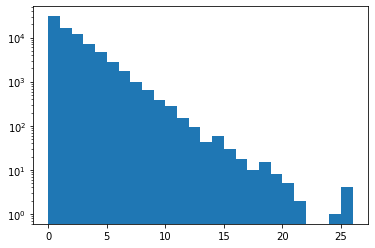

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
keyword_counts = title_keyword_data.loc[:, 'title_question_overlap_clean'].apply(len).values
plt.hist(keyword_counts, bins=keyword_counts.max())
plt.yscale('log')
plt.show()

More than half the questions have 0 keywords in the question, but we have a long tail of high-overlap questions. These questions could be copying text verbatim but TBD.

In [8]:
## split into training/val
from importlib import reload
import demo_keyword_extractor
reload(demo_keyword_extractor)
from demo_keyword_extractor import build_dataset
from transformers import DistilBertTokenizer
train_pct = 0.8
val_pct = 0.1
N_data = title_keyword_data.shape[0]
title_keyword_data = title_keyword_data.sample(N_data, replace=False, random_state=123)
train_data = title_keyword_data[:int(N_data*train_pct)]
val_data = title_keyword_data[int(N_data*train_pct):int(N_data*(train_pct+val_pct))]
test_data = title_keyword_data[int(N_data*(train_pct+val_pct)):]
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
max_length = 512
train_dataset = build_dataset(tokenizer, 
                              train_data.loc[:, 'title'].values.tolist(), 
                              train_data.loc[:, 'title_question_overlap_clean'].values.tolist(),
                              max_length=max_length,
                             )
val_dataset = build_dataset(tokenizer, 
                            val_data.loc[:, 'title'].values.tolist(), 
                            val_data.loc[:, 'title_question_overlap_clean'].values.tolist(),
                            max_length=max_length,
                           )

In [9]:
print(len(train_dataset))
print(len(val_dataset))

62486
7811


In [10]:
## set up GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [12]:
from transformers import TrainingArguments
from demo_keyword_extractor import KeywordLossTrainer
from importlib import reload
import transformers
reload(transformers)
from transformers import DistilBertForTokenClassification
model_name = 'distilbert-base-uncased'
model = DistilBertForTokenClassification.from_pretrained(model_name, cache_dir='../../data/model_cache/')
training_args = TrainingArguments(output_dir='runs/', num_train_epochs=5, save_total_limit=1)
trainer = KeywordLossTrainer(model=model, train_dataset=train_dataset, eval_dataset=val_dataset, args=training_args)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

In [14]:
## train!
train_output = trainer.train()

***** Running training *****
  Num examples = 62486
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39055


Step,Training Loss
500,0.108600
1000,0.102900
1500,0.099000
2000,0.098600
2500,0.096400
3000,0.096900
3500,0.097300
4000,0.096500
4500,0.097700
5000,0.096100


Saving model checkpoint to runs/checkpoint-500
Configuration saved in runs/checkpoint-500/config.json
Model weights saved in runs/checkpoint-500/pytorch_model.bin
Saving model checkpoint to runs/checkpoint-1000
Configuration saved in runs/checkpoint-1000/config.json
Model weights saved in runs/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [runs/checkpoint-500] due to args.save_total_limit
Saving model checkpoint to runs/checkpoint-1500
Configuration saved in runs/checkpoint-1500/config.json
Model weights saved in runs/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [runs/checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to runs/checkpoint-2000
Configuration saved in runs/checkpoint-2000/config.json
Model weights saved in runs/checkpoint-2000/pytorch_model.bin
Deleting older checkpoint [runs/checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to runs/checkpoint-2500
Configuration saved in runs/checkpoint-2500/config.json
Mo

Deleting older checkpoint [runs/checkpoint-18000] due to args.save_total_limit
Saving model checkpoint to runs/checkpoint-19000
Configuration saved in runs/checkpoint-19000/config.json
Model weights saved in runs/checkpoint-19000/pytorch_model.bin
Deleting older checkpoint [runs/checkpoint-18500] due to args.save_total_limit
Saving model checkpoint to runs/checkpoint-19500
Configuration saved in runs/checkpoint-19500/config.json
Model weights saved in runs/checkpoint-19500/pytorch_model.bin
Deleting older checkpoint [runs/checkpoint-19000] due to args.save_total_limit
Saving model checkpoint to runs/checkpoint-20000
Configuration saved in runs/checkpoint-20000/config.json
Model weights saved in runs/checkpoint-20000/pytorch_model.bin
Deleting older checkpoint [runs/checkpoint-19500] due to args.save_total_limit
Saving model checkpoint to runs/checkpoint-20500
Configuration saved in runs/checkpoint-20500/config.json
Model weights saved in runs/checkpoint-20500/pytorch_model.bin
Deleting

Saving model checkpoint to runs/checkpoint-35500
Configuration saved in runs/checkpoint-35500/config.json
Model weights saved in runs/checkpoint-35500/pytorch_model.bin
Deleting older checkpoint [runs/checkpoint-35000] due to args.save_total_limit
Saving model checkpoint to runs/checkpoint-36000
Configuration saved in runs/checkpoint-36000/config.json
Model weights saved in runs/checkpoint-36000/pytorch_model.bin
Deleting older checkpoint [runs/checkpoint-35500] due to args.save_total_limit
Saving model checkpoint to runs/checkpoint-36500
Configuration saved in runs/checkpoint-36500/config.json
Model weights saved in runs/checkpoint-36500/pytorch_model.bin
Deleting older checkpoint [runs/checkpoint-36000] due to args.save_total_limit
Saving model checkpoint to runs/checkpoint-37000
Configuration saved in runs/checkpoint-37000/config.json
Model weights saved in runs/checkpoint-37000/pytorch_model.bin
Deleting older checkpoint [runs/checkpoint-36500] due to args.save_total_limit
Saving m

In [15]:
## evaluate
trainer.evaluate()

{'eval_loss': 0.10143487900495529,
 'eval_runtime': 58.5582,
 'eval_samples_per_second': 133.389,
 'eval_steps_per_second': 16.684,
 'epoch': 5.0}

How well does this model do with the test data??

In [16]:
## reload model
final_model = DistilBertForTokenClassification.from_pretrained('runs/checkpoint-39000/')
print(final_model)

loading configuration file runs/checkpoint-39000/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForTokenClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.14.1",
  "vocab_size": 30522
}

loading weights file runs/checkpoint-39000/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForTokenClassification.

All the weights of DistilBertForTokenClassification were initialized from the model checkpoint at runs/checkpoint-39000/.
If your task is similar to the task the model of the checkpoint was tr

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
          

In [17]:
test_dataset = build_dataset(tokenizer, 
                            test_data.loc[:, 'title'].values.tolist(), 
                            test_data.loc[:, 'title_question_overlap_clean'].values.tolist(),
                            max_length=max_length,
                           )

In [31]:
## run prediction
import torch
from tqdm import tqdm
final_model.eval()
with torch.no_grad():
    test_output = [final_model(**{k : v.to(final_model.device).unsqueeze(1) for k,v in x.items()}) for x in tqdm(test_dataset)]

100%|██████████| 7811/7811 [16:24<00:00,  7.93it/s]


What is the overall performance score for the output data?

In [134]:
import demo_keyword_extractor
reload(demo_keyword_extractor)
from demo_keyword_extractor import keyword_score
def compute_metrics(p, null_ids={101}):
    predictions, labels, inputs = p
    # nan values don't matter because argmax converts to 0
    # fix nan vals in prediction => set to 0
#     nan_idx = np.where(torch.isnan(predictions).min(1)[0])
#     predictions[torch.isnan(predictions)]
    predictions = predictions.argmax(axis=1)
    input_pred = [int(i) for i,o in zip(inputs, predictions) if o==1 and int(i) not in null_ids]
    input_labels = [int(i) for i,l in zip(inputs, labels) if l==1]
#     print(input_pred, input_labels)
    prec, rec, F1 = keyword_score(input_pred, input_labels)
    return {
        'prec' : prec,
        'rec' : rec,
        'F1' : F1,
        'pred_ids' : input_pred,
        'label_ids' : input_labels,
    }

In [ ]:
test_data_metrics = []
for pred_i, test_data_i in tqdm(zip(test_output, test_dataset), total=len(test_dataset)):
    test_data_metric = compute_metrics((pred_i.logits.squeeze(1), test_data_i['labels'], test_data_i['input_ids']))
    test_data_metrics.append(test_data_metric)
test_data_metrics = pd.DataFrame(test_data_metrics)
test_data_metrics.index = test_data.index

 19%|█▉        | 1502/7811 [00:20<01:26, 72.75it/s]

What are the overall metrics (all data, only data with at least 1 label)?

In [137]:
metric_cols = ['prec', 'rec', 'F1']
print(test_data_metrics.loc[:, metric_cols].mean(axis=0))
test_data_with_labels_metrics = test_data_metrics[test_data_metrics.loc[:, 'label_ids'].apply(lambda x: len(x) > 0)]
print(f'N={test_data_with_labels_metrics.shape[0]} data with at least one label')
print(test_data_with_labels_metrics.loc[:, metric_cols].mean(axis=0))

prec    0.032369
rec     0.076026
F1      0.054197
dtype: float64
N=4312 data with at least one label
prec    0.058634
rec     0.137717
F1      0.098176
dtype: float64


The model does slightly better when predicting on posts with at least one label.

Let's look at a few of those as examples!

In [142]:
## recombine with original data
test_pred_data = pd.concat([
    test_data,
    test_data_metrics.loc[:, ['prec', 'rec', 'F1', 'pred_ids', 'label_ids']],
], axis=1)
null_ids = {101}
test_pred_data = test_pred_data.assign(**{
    'pred_tokens' : test_pred_data.loc[:, 'pred_ids'].apply(lambda x: tokenizer.convert_ids_to_tokens(list(filter(lambda y: y not in null_ids, x)))),
    'label_tokens' : test_pred_data.loc[:, 'label_ids'].apply(lambda x: tokenizer.convert_ids_to_tokens(list(filter(lambda y: y not in null_ids, x)))),
})
display(test_pred_data.head())

,id_submission,id_comment,title,reply_question,title_tokens,title_tokens_clean,question_tokens,question_tokens_clean,title_question_overlap_clean,prec,rec,F1,pred_ids,label_ids,pred_tokens,label_tokens
17989,gehvui,fpon6na,Why do viruses often come from bats? A discussion with your friendly neighborhood virologist,Is there even solid evidence that fever actually does anything?,"[why, do, viruses, often, come, from, bats, ?, a, discussion, with, your, friendly, neighborhood, vi, ##rol, ##ogist]","[whi, do, virus, often, come, from, bat, ?, a, discuss, with, your, friendli, neighborhood, vi, ##rol, ##ogist]","[is, there, even, solid, evid, that, fever, actual, doe, anyth, ?]","[is, there, even, solid, evid, that, fever, actual, doe, anyth, ?]",[],0.000000,0.000000,0.000000,"[1029, 2007, 6819]",[],"[?, with, vi]",[]
9007,ijkedb,g3g4f0x,"For the first time, scientists just replicated pressures found on white dwarf stars in a lab on earth.",Will it be possible to create neutronium or quarks or a small black hole?,"[for, the, first, time, ,, scientists, just, replicate, ##d, pressures, found, on, white, dwarf, stars, in, a, lab, on, earth, .]","[for, the, first, time, ,, scientist, just, replic, ##d, pressur, found, on, white, dwarf, star, in, a, lab, on, earth, .]","[will, it, be, possibl, to, creat, neutron, ##ium, or, qu, ##ark, ##, or, a, small, black, hole, ?]","[will, it, be, possibl, to, creat, neutron, ##ium, or, qu, ##ark, ##, or, a, small, black, hole, ?]",[],0.000000,0.000000,0.000000,"[2034, 2051, 2006, 2006]",[],"[first, time, on, on]",[]
71656,jm1vii,gatd830,"Researchers have showed for the first time that the body produces more stress hormones when people are repeatedly interrupted at work. Should this stress become chronic, it can lead to states of e...","Should this stress becomes chronic, it can lead to states of exhaustion that have a negative impact on public health and carry a significant economic cost""?","[researchers, have, showed, for, the, first, time, that, the, body, produces, more, stress, hormones, when, people, are, repeatedly, interrupted, at, work, ., should, this, stress, become, chronic...","[research, have, show, for, the, first, time, that, the, bodi, produc, more, stress, hormon, when, peopl, are, repeatedli, interrupt, at, work, ., should, thi, stress, becom, chronic, ,, it, can, ...","[should, thi, stress, becom, chronic, ,, it, can, lead, to, state, of, exhaust, that, have, a, n, eg, at, ive, impact, on, public, health, and, carri, a, sign, ##if, ##i, cant, econom, cost, "", ?]","[should, thi, stress, becom, chronic, ,, it, can, lead, to, state, of, exhaust, that, have, a, n, eg, at, ive, impact, on, public, health, and, carri, a, sign, ##if, ##i, cant, econom, cost, "", ?]","[stress, stress, become, chronic, lead, states, exhaustion, n, eg, ive, impact, public, health, carry, sign, cant, economic, cost]",0.200000,0.083333,0.141667,"[2034, 2051, 2323, 15575, 2006]","[6911, 6911, 2468, 11888, 2599, 2163, 15575, 4254, 2270, 2740, 4287, 3171, 3465]","[first, time, should, exhaustion, on]","[stress, stress, become, chronic, lead, states, exhaustion, impact, public, health, carry, economic, cost]"
25274,kklv00,gh5vqm3,Clearing land to feed a growing human population will threaten thousands of species,"How economically viable is aquaponics, vertical farming, and vegetables grown in artificial environments (with artificial lights)?","[clearing, land, to, feed, a, growing, human, population, will, threaten, thousands, of, species]","[clear, land, to, feed, a, grow, human, popul, will, threaten, thousand, of, speci]","[how, econom, viabl, is, aqua, ##pon, ##ic, ,, vertic, farm, ,, and, v, eg, eta, ##ble, grown, in, artifici, environ, (, with, artifici, light, ), ?]","[how, econom, viabl, is, aqua, ##pon, ##ic, ,, vertic, farm, ,, and, v, eg, eta, ##ble, grown, in, artifici, environ, (, with, artifici, light, ), ?]",[],0.000000,0.000000,0.000000,"[2455, 2097]",[],"[land, will]",[]
26637,ibicdy,g1xu6y4,

In [147]:
pd.set_option('display.max_colwidth', 500)
display_cols = ['title', 'reply_question', 'pred_tokens', 'label_tokens', 'prec', 'rec', 'F1']
print('correct preds')
display(test_pred_data.sort_values('F1', ascending=False).loc[:, display_cols].head(20))
print('incorrect preds')
display(test_pred_data.sort_values('F1', ascending=True).loc[:, display_cols].head(20))

correct preds


,title,reply_question,pred_tokens,label_tokens,prec,rec,F1
69312,"Blue jeans are a significant source of microfiber pollution in oceans and lakes. One pair of jeans can release over 50,000 microfibers per wash.","If people don't care what's on their plate, why should they care about what's far away in some lake?",[lakes],[lakes],1.0,1.000000,1.000000
72209,New dinosaur species found in Australia was as long as a basketball court,"A lot of dinsaurs were that long, why is that the distinguishing fact?",[long],[long],1.0,1.000000,1.000000
60037,Chest beats as an honest signal of body size in male mountain gorillas,Could gorillas not just evolve to larger chests without being better fighters and otherwise better mates?,"[chest, gorilla]","[chest, gorilla]",1.0,1.000000,1.000000
71172,"Pets More Effective for Grief Support than Humans, Study Finds",What is effective for grieving the lost of a pet?,[pets],[pets],1.0,1.000000,1.000000
34788,Fatal school shootings linked to increased antidepressant use among youths,"Is this the same study group that found divorce in America rose after the growth of margarine use in the USA , just askin?",[use],[use],1.0,1.000000,1.000000
20414,"People’s attachment to the wilderness is linked to the fulfillment of basic psychological needs, study finds","Did a woods support your needs for food, clothing and shelter?",[needs],[needs],1.0,1.000000,1.000000
34715,Electric catfish cannot be shocked and scientists don’t know why,"Could be dumb or mentioned already, but you think the defense is in place so they don’t shock their own accidentally?",[shocked],[shocked],1.0,1.000000,1.000000
55606,New battery electrolyte developed at Stanford may boost the performance of electric vehicles,So what is the reason this tech won’t just follow similar developments and never reach mass production?,[developed],[developed],1.0,1.000000,1.000000
17385,Humans judge faces in incomplete photographs as physically more attractive,So would hiding half my face behind long hair make me seem more attractive then?,[faces],[faces],1.0,1.000000,1.000000
67695,Vikings not typically blonde according to Genomes,What's the deal with the anti-white-washing of the vikings?,[vikings],[vikings],1.0,1.000000,1.000000


incorrect preds


,title,reply_question,pred_tokens,label_tokens,prec,rec,F1
17989,Why do viruses often come from bats? A discussion with your friendly neighborhood virologist,Is there even solid evidence that fever actually does anything?,"[?, with, vi]",[],0.0,0.0,0.0
34378,"Use of genetically modified eggplant in Bangladesh increased the yield by 51%, decreased pesticide use by 37%, increased farmer profits, and reduced reporting of sickness tied to pesticide poisoning. [Evidence from randomized control trials]",What is it doing to the soil long term?,"[use, by, use, by, 37, reduced, [, ]]",[],0.0,0.0,0.0
1278,"Conservatives and liberals differ on COVID-19 because conservatives tend to attribute negative outcomes to purposeful actions by threats high in agency. If health officials talked about the virus as a palpable enemy that is seeking to attack humans, they may get greater buy-in from conservatives.",So... We have to discuss covid with conservatives like we do when we frame the concepts for small children?,"[on, ##vid, -, tend, attribute, purpose, actions, by, about, ##pa, buy, -]",[],0.0,0.0,0.0
73001,"DEA moves toward approving more research for Marijuana growers. 36 states now permit marijuana to be used medically, and 17 allow recreational use. Yet researchers who wish to study the drug’s health effects have been limited since 1968 to a single legal supplier of the drug.",Interesting read but is it really appropriate for this sub?,"[dea, moves, app, 36, 17, use, wish, since]",[],0.0,0.0,0.0
7690,"Smokers who scored higher on a test of math ability were more likely to say they intended to quit smoking, says an online study of Americans. The reason: They had a better memory for smoking risk stats, which led to perceiving a greater risk from smoking and then a greater intention to quit.",The title implies causation but is that even established in the study itself?,"[on, likely, intended, says, ##iving, intention]",[study],0.0,0.0,0.0
59807,"People’s attachment to the wilderness is linked to the fulfillment of basic psychological needs, study finds",I'm amazed how something that basic is... rediscovered?,[needs],[basic],0.0,0.0,0.0
60674,About 1 in 3 patients were diagnosed with psychiatric or neurological illnesses in the 6 months following COVID-19 diagnosis (n=236379). An even greater proportion (46%) of patients who were hospitalized received such diagnoses.,What percent of the population has a psychiatric problem?,"[about, 1, 3, with, 6, ##vid, -, (, 236, (, ##ses]",[psychiatric],0.0,0.0,0.0
57890,"Studies reveal that location tracking apps do more than just monitor your whereabouts; they collect a lot of sensitive information about the user's residence, habits, interests, demographics, and personality traits","Aside from the breach of privacy, what’s my risk here if I have nothing to hide?","[lot, about, ', personality, traits]",[],0.0,0.0,0.0
9261,"Blood clotting a significant cause of death in patients with COVID-19. ""COVID-19 is associated with a unique type of blood clotting disorder that is primarily focussed within the lungs &amp; which undoubtedly contributes to the high levels of mortality being seen in patients with COVID-19"".","So what they are saying is, I should continue taking my blood thinners?","[cl, ##otti, ##ng, with, ##vid, -, "", ##vid, -, associated, with, cl, ##otti, ##ng, primarily, amp, contributes, with, ##vid, -, ""]","[blood, blood]",0.0,0.0,0.0
37567,Average male punching power found to be 162% (2.62x) greater than average female punching power; the weakest male in the study still outperformed the strongest female; n=39,and how do they differ between males and females?,"[(, ##x, weak, ##formed, strongest]","[male, female, male, female]",0.0,0.0,0.0


- Correct predictions:
    - Copying individual words from title (`needs`; `long`, `use`)
    - Engaging with content ([`chest`, `gorilla`]; `shock`)
- Incorrect predictions: 
    - Focusing on tangential aspects of study ([`weak`, `strongest`] vs. [`male`, `female`]; [`palette`, `harness`] vs. [`colors`])
    - Overgeneration ([`supervisors`, `employee`] vs. [])

In [ ]:
## extract relevant words: proper nouns, noun chunks, verbs

### Question generation
1. Can we generate the questions asked in comments based on the post text?
2. Can we do this for specific reader groups?

In [ ]:
## TODO: taxonomy of clarification questions

